In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression

# Neural Network imports
from sklearn.neural_network import MLPRegressor


In [255]:
df_raw = pd.read_csv("/content/drive/MyDrive/ConceptAndTechnologiesOfAI/Regression_Dataset/Advanced Soybean Agricultural Dataset.csv")

In [256]:
df = df_raw.copy()

In [257]:
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

Dataset Shape: 55,450 rows × 15 columns


In [258]:
print(f"\nColumn Names and Types:")
print(df.dtypes)


Column Names and Types:
Parameters                                  object
Random                                      object
Plant Height (PH)                          float64
Number of Pods (NP)                        float64
Biological Weight (BW)                     float64
Sugars (Su)                                float64
Relative Water Content in Leaves (RWCL)    float64
ChlorophyllA663                            float64
Chlorophyllb649                            float64
Protein Percentage (PPE)                   float64
Weight of 300 Seeds (W3S)                  float64
Leaf Area Index (LAI)                      float64
Seed Yield per Unit Area (SYUA)            float64
Number of Seeds per Pod (NSP)              float64
Protein Content (PCO)                      float64
dtype: object


In [259]:
df.head()

,Parameters,Random,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),Seed Yield per Unit Area (SYUA),Number of Seeds per Pod (NSP),Protein Content (PCO)
0,C1S1G5,R1,50.5,130.3,111.0,0.433,0.732,1.4,3.1,33.2,33.6,0.08,5567.4,1.86,0.82
1,C2S3G4,R1,44.5,132.0,80.0,0.334,0.674,7.1,2.2,38.5,34.4,0.09,2245.5,1.87,0.13
2,C2S1G6,R1,52.2,150.0,83.0,0.490,0.677,1.8,1.3,33.6,35.2,0.07,4326.7,2.04,0.15
3,C1S1G1,R1,50.5,140.8,66.0,0.163,0.745,1.1,3.0,33.5,52.3,0.09,6214.5,2.20,0.14
4,C1S2G6,R2,49.2,175.6,73.0,0.795,0.725,7.5,2.1,39.6,31.2,0.10,3897.8,1.88,0.60


In [260]:
# Missing values
missing_data = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_data) > 0:
    print("Missing Values Detected:")
    print(missing_data)
else:
    print("No missing values detected in the dataset")

No missing values detected in the dataset


In [261]:
# Duplicate rows
duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")


Duplicate Rows: 55,342 (99.81%)


In [262]:
print(df.columns.tolist())

['Parameters', 'Random ', 'Plant Height (PH)', 'Number of Pods (NP)', 'Biological Weight (BW)', 'Sugars (Su)', 'Relative Water Content in Leaves (RWCL)', 'ChlorophyllA663', 'Chlorophyllb649', 'Protein Percentage (PPE)', 'Weight of 300 Seeds (W3S)', 'Leaf Area Index (LAI)', 'Seed Yield per Unit Area (SYUA)', 'Number of Seeds per Pod (NSP)', 'Protein Content (PCO)']


In [263]:
df.columns = df.columns.str.strip()

In [264]:
df.columns.tolist()

['Parameters',
 'Random',
 'Plant Height (PH)',
 'Number of Pods (NP)',
 'Biological Weight (BW)',
 'Sugars (Su)',
 'Relative Water Content in Leaves (RWCL)',
 'ChlorophyllA663',
 'Chlorophyllb649',
 'Protein Percentage (PPE)',
 'Weight of 300 Seeds (W3S)',
 'Leaf Area Index (LAI)',
 'Seed Yield per Unit Area (SYUA)',
 'Number of Seeds per Pod (NSP)',
 'Protein Content (PCO)']

In [265]:
df.duplicated(subset=['Parameters', 'Random']).sum()


np.int64(55345)

In [266]:
df = df.rename(columns={
    'Parameters': 'Genotype',
    'Random': 'Replication'
})

In [267]:
df.duplicated(subset=['Genotype', 'Replication']).sum()

np.int64(55345)

In [268]:
df_agg = (
    df.groupby('Genotype', as_index=False)
      .mean(numeric_only=True)
)

print(df_agg.shape)
df_agg.head()

(35, 14)


,Genotype,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),Seed Yield per Unit Area (SYUA),Number of Seeds per Pod (NSP),Protein Content (PCO)
0,C1S1G1,50.333442,141.266364,66.999351,0.163000,0.728677,1.233247,3.133247,35.465390,52.566494,0.080006,6320.397857,2.110058,0.140000
1,C1S1G2,50.534545,137.232532,224.665584,0.537990,0.723660,1.866688,3.200065,38.066753,37.367143,0.070000,5134.253247,2.033351,0.506662
2,C1S1G3,49.098636,131.231883,135.332468,0.756992,0.718003,7.200000,1.200065,38.399481,33.033442,0.083338,2743.787208,2.046766,0.500000
3,C1S1G4,45.200260,158.999351,95.000000,0.533993,0.669992,6.000000,1.199935,38.666234,45.699740,0.093338,4422.015779,1.913422,1.143318
4,C1S1G5,51.299481,129.767013,112.665584,0.436997,0.739662,1.233442,3.266558,34.965519,36.131688,0.089994,5560.237987,2.219766,0.673429


In [269]:
df_agg.describe().T


,count,mean,std,min,25%,50%,75%,max
Plant Height (PH),35.0,49.920996,2.974640,41.666256,49.733506,50.534545,51.299805,55.300000
Number of Pods (NP),35.0,145.017077,14.184156,124.200519,132.575065,142.154398,157.216807,181.154221
Biological Weight (BW),35.0,114.172684,47.287102,33.332468,81.833550,102.001299,131.500324,234.667748
Sugars (Su),35.0,0.468986,0.222101,0.162666,0.306668,0.459671,0.603322,1.068718
Relative Water Content in Leaves (RWCL),35.0,0.676883,0.078597,0.458349,0.646001,0.669992,0.724008,0.852988
ChlorophyllA663,35.0,3.972879,2.902111,1.099935,1.466840,2.533506,6.699935,10.033247
Chlorophyllb649,35.0,2.404773,1.185893,1.166645,1.400227,2.200065,3.116656,7.599805
Protein Percentage (PPE),35.0,36.085476,1.608561,32.300000,35.101417,35.632662,37.116299,39.166948
Weight of 300 Seeds (W3S),35.0,35.413834,4.937485,27.300584,33.059061,34.399286,36.417034,52.566494
Leaf Area Index (LAI),35.0,0.071906,0.020679,0.030006,0.059994,0.076675,0.089994,0.096671


In [270]:
df_agg.isna().sum()


,0
Genotype,0
Plant Height (PH),0
Number of Pods (NP),0
Biological Weight (BW),0
Sugars (Su),0
Relative Water Content in Leaves (RWCL),0
ChlorophyllA663,0
Chlorophyllb649,0
Protein Percentage (PPE),0
Weight of 300 Seeds (W3S),0


In [271]:
numeric_df = df_agg.select_dtypes(include='number')

variance_df = pd.DataFrame({
    'Variance': numeric_df.var(),
    'Std_Dev': numeric_df.std()
}).sort_values(by='Variance', ascending=False)

variance_df


,Variance,Std_Dev
Seed Yield per Unit Area (SYUA),1.470011e+06,1212.440006
Biological Weight (BW),2.236070e+03,47.287102
Number of Pods (NP),2.011903e+02,14.184156
Weight of 300 Seeds (W3S),2.437875e+01,4.937485
Plant Height (PH),8.848486e+00,2.974640
ChlorophyllA663,8.422250e+00,2.902111
Protein Percentage (PPE),2.587470e+00,1.608561
Chlorophyllb649,1.406341e+00,1.185893
Protein Content (PCO),7.901251e-02,0.281092
Sugars (Su),4.932893e-02,0.222101


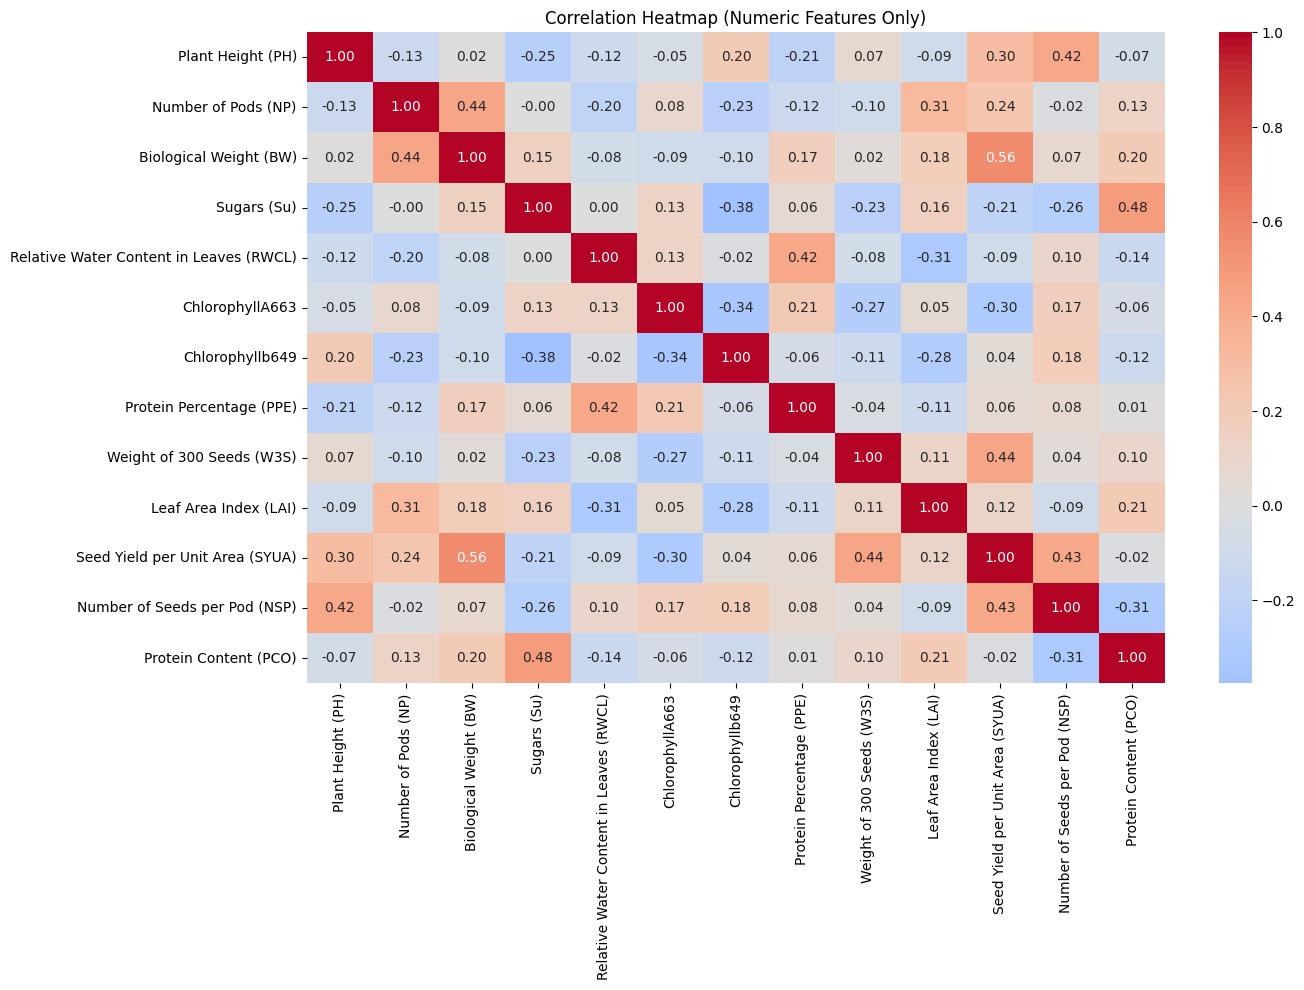

In [272]:
df_num = df_agg.select_dtypes(include='number')

plt.figure(figsize=(14, 10))
sns.heatmap(
    df_num.corr(),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title('Correlation Heatmap (Numeric Features Only)')
plt.tight_layout()
plt.show()


In [273]:
# Data types
print(f"\nData Type Distribution:")
print(df.dtypes.value_counts())
print("\n")


Data Type Distribution:
float64    13
object      2
Name: count, dtype: int64




In [274]:
print("\n1.2 Column Names and Data Types:")
print(df.dtypes)

print("\n1.3 First 10 Rows:")
print(df.head(10))

print("\n1.4 Last 10 Rows:")
print(df.tail(10))

print("\n1.5 Dataset Info:")
df.info()



1.2 Column Names and Data Types:
Genotype                                    object
Replication                                 object
Plant Height (PH)                          float64
Number of Pods (NP)                        float64
Biological Weight (BW)                     float64
Sugars (Su)                                float64
Relative Water Content in Leaves (RWCL)    float64
ChlorophyllA663                            float64
Chlorophyllb649                            float64
Protein Percentage (PPE)                   float64
Weight of 300 Seeds (W3S)                  float64
Leaf Area Index (LAI)                      float64
Seed Yield per Unit Area (SYUA)            float64
Number of Seeds per Pod (NSP)              float64
Protein Content (PCO)                      float64
dtype: object

1.3 First 10 Rows:
  Genotype Replication  Plant Height (PH)  Number of Pods (NP)  \
0   C1S1G5          R1               50.5                130.3   
1   C2S3G4          R1             

In [275]:
print("\n2.1 Missing Values Analysis:")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df)

if missing_df.empty:
    print("No missing values found in the dataset!")
else:
    print(f"\n⚠ Total columns with missing values: {len(missing_df)}")

print("\n2.2 Duplicate Rows:")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df))*100:.2f}%")
else:
    print("No duplicate rows found!")

print("\n2.3 Data Types Verification:")
for col in df.columns:
    print(f"{col:40s} - {df[col].dtype}")


2.1 Missing Values Analysis:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []
No missing values found in the dataset!

2.2 Duplicate Rows:
Number of duplicate rows: 55342
Percentage of duplicates: 99.81%

2.3 Data Types Verification:
Genotype                                 - object
Replication                              - object
Plant Height (PH)                        - float64
Number of Pods (NP)                      - float64
Biological Weight (BW)                   - float64
Sugars (Su)                              - float64
Relative Water Content in Leaves (RWCL)  - float64
ChlorophyllA663                          - float64
Chlorophyllb649                          - float64
Protein Percentage (PPE)                 - float64
Weight of 300 Seeds (W3S)                - float64
Leaf Area Index (LAI)                    - float64
Seed Yield per Unit Area (SYUA)          - float64
Number of Seeds per Pod (NSP)            - float64
Protein Content (PCO)  

In [276]:
print("\n3.1 Summary Statistics for Numerical Features:")
print(df.describe().T)

print("\n3.2 Summary Statistics with Additional Metrics:")
stats_df = pd.DataFrame({
    'count': df.describe().loc['count'],
    'mean': df.describe().loc['mean'],
    'std': df.describe().loc['std'],
    'min': df.describe().loc['min'],
    '25%': df.describe().loc['25%'],
    'median': df.describe().loc['50%'],
    '75%': df.describe().loc['75%'],
    'max': df.describe().loc['max'],
    'range': df.describe().loc['max'] - df.describe().loc['min'],
    'IQR': df.describe().loc['75%'] - df.describe().loc['25%'],
    'skewness': df.select_dtypes(include=[np.number]).skew(),
    'kurtosis': df.select_dtypes(include=[np.number]).kurtosis()
})
print(stats_df)

print("\n3.3 Categorical Features Analysis:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"Unique values: {df[col].nunique()}")



3.1 Summary Statistics for Numerical Features:
                                           count         mean          std  \
Plant Height (PH)                        55450.0    49.959392     3.052315   
Number of Pods (NP)                      55450.0   144.938979    20.015994   
Biological Weight (BW)                   55450.0   114.533886    48.925533   
Sugars (Su)                              55450.0     0.477543     0.236294   
Relative Water Content in Leaves (RWCL)  55450.0     0.673621     0.084515   
ChlorophyllA663                          55450.0     3.937670     2.846317   
Chlorophyllb649                          55450.0     2.399096     1.187323   
Protein Percentage (PPE)                 55450.0    36.042123     2.417205   
Weight of 300 Seeds (W3S)                55450.0    35.349129     4.999200   
Leaf Area Index (LAI)                    55450.0     0.072132     0.022278   
Seed Yield per Unit Area (SYUA)          55450.0  4388.525773  1251.490529   
Number of Seeds 

In [277]:
# Create a copy for processing
df_processed = df.copy()

print("\n4.1 Handling Missing Values:")
# Check for missing values
if df_processed.isnull().sum().sum() > 0:
    print("Missing values detected. Applying imputation...")
    # Impute numerical columns with median
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_processed[col].isnull().sum() > 0:
            median_val = df_processed[col].median()
            df_processed[col].fillna(median_val, inplace=True)
            print(f"  - Filled {col} with median: {median_val:.2f}")

    # Impute categorical columns with mode
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            mode_val = df_processed[col].mode()[0]
            df_processed[col].fillna(mode_val, inplace=True)
            print(f"  - Filled {col} with mode: {mode_val}")
else:
    print("No missing values to handle!")

print("\n4.2 Removing Duplicates:")
before_dup = len(df_processed)
df_processed.drop_duplicates(inplace=True)
after_dup = len(df_processed)
print(f"Rows before: {before_dup:,}")
print(f"Rows after: {after_dup:,}")
print(f"Duplicates removed: {before_dup - after_dup}")

print("\n4.3 Outlier Detection using IQR Method:")
numerical_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()

outlier_summary = []
for col in numerical_features:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df_processed)) * 100

    outlier_summary.append({
        'Feature': col,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Outliers': outlier_count,
        'Outlier_Percentage': outlier_pct
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df)

print("\n4.4 Encoding Categorical Variables:")
# Identify categorical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    print(f"Categorical columns to encode: {categorical_cols}")
    le_dict = {}

    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
        le_dict[col] = le
        print(f"  - Encoded {col}: {len(le.classes_)} unique classes")
        print(f"    Classes: {le.classes_[:10]}...")  # Show first 10 classes
else:
    print(" No categorical columns to encode!")

print("\n4.5 Feature Engineering:")
print("-" * 40)
# Create interaction features if relevant
if 'Plant Height (PH)' in df_processed.columns and 'Number of Pods (NP)' in df_processed.columns:
    df_processed['PH_NP_ratio'] = df_processed['Plant Height (PH)'] / (df_processed['Number of Pods (NP)'] + 1)
    print("Created feature: PH_NP_ratio")

if 'Biological Weight (BW)' in df_processed.columns and 'Number of Pods (NP)' in df_processed.columns:
    df_processed['BW_per_pod'] = df_processed['Biological Weight (BW)'] / (df_processed['Number of Pods (NP)'] + 1)
    print("Created feature: BW_per_pod")

if 'Weight of 300 Seeds (W3S)' in df_processed.columns:
    df_processed['Seed_weight_per_unit'] = df_processed['Weight of 300 Seeds (W3S)'] / 300
    print("Created feature: Seed_weight_per_unit")

print(f"\nDataset shape after preprocessing: {df_processed.shape}")



4.1 Handling Missing Values:
No missing values to handle!

4.2 Removing Duplicates:
Rows before: 55,450
Rows after: 108
Duplicates removed: 55342

4.3 Outlier Detection using IQR Method:
                                    Feature  Lower_Bound  Upper_Bound  \
0                         Plant Height (PH)     45.00000     56.20000   
1                       Number of Pods (NP)     90.87500    198.27500   
2                    Biological Weight (BW)      1.00000    211.00000   
3                               Sugars (Su)     -0.18150      1.08850   
4   Relative Water Content in Leaves (RWCL)      0.49850      0.85650   
5                           ChlorophyllA663     -6.43750     14.66250   
6                           Chlorophyllb649     -1.40000      5.80000   
7                  Protein Percentage (PPE)     27.00000     44.60000   
8                 Weight of 300 Seeds (W3S)     24.66250     44.76250   
9                     Leaf Area Index (LAI)      0.00875      0.13875   
10       


5.1 Target Variable Distribution:


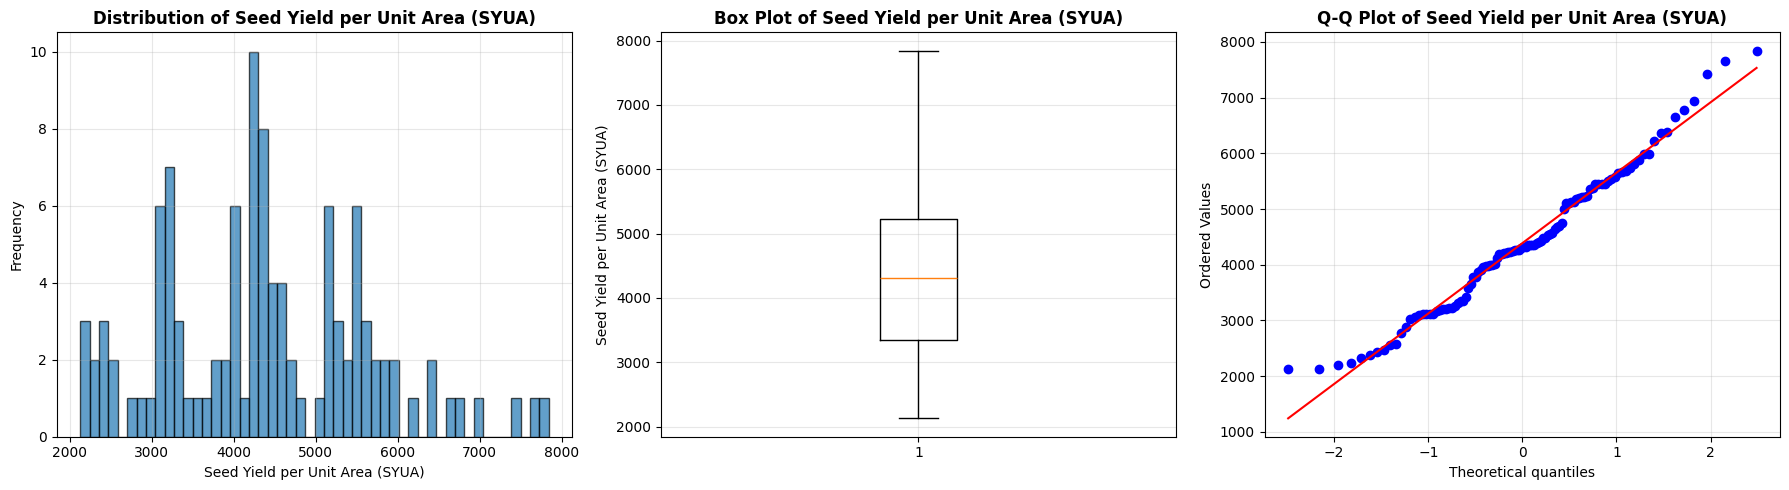

Target Variable Statistics:
  Mean: 4388.41
  Median: 4312.70
  Std Dev: 1257.26
  Skewness: 0.38
  Kurtosis: -0.07


In [278]:
# 5.1 Distribution of Target Variable
print("\n5.1 Target Variable Distribution:")
target_var = 'Seed Yield per Unit Area (SYUA)'

if target_var in df_processed.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Histogram
    axes[0].hist(df_processed[target_var], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title(f'Distribution of {target_var}', fontsize=12, fontweight='bold')
    axes[0].set_xlabel(target_var)
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)

    # Box plot
    axes[1].boxplot(df_processed[target_var], vert=True)
    axes[1].set_title(f'Box Plot of {target_var}', fontsize=12, fontweight='bold')
    axes[1].set_ylabel(target_var)
    axes[1].grid(True, alpha=0.3)

    # Q-Q plot
    stats.probplot(df_processed[target_var], dist="norm", plot=axes[2])
    axes[2].set_title(f'Q-Q Plot of {target_var}', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Target Variable Statistics:")
    print(f"  Mean: {df_processed[target_var].mean():.2f}")
    print(f"  Median: {df_processed[target_var].median():.2f}")
    print(f"  Std Dev: {df_processed[target_var].std():.2f}")
    print(f"  Skewness: {df_processed[target_var].skew():.2f}")
    print(f"  Kurtosis: {df_processed[target_var].kurtosis():.2f}")



5.2 Distribution of Numerical Features:


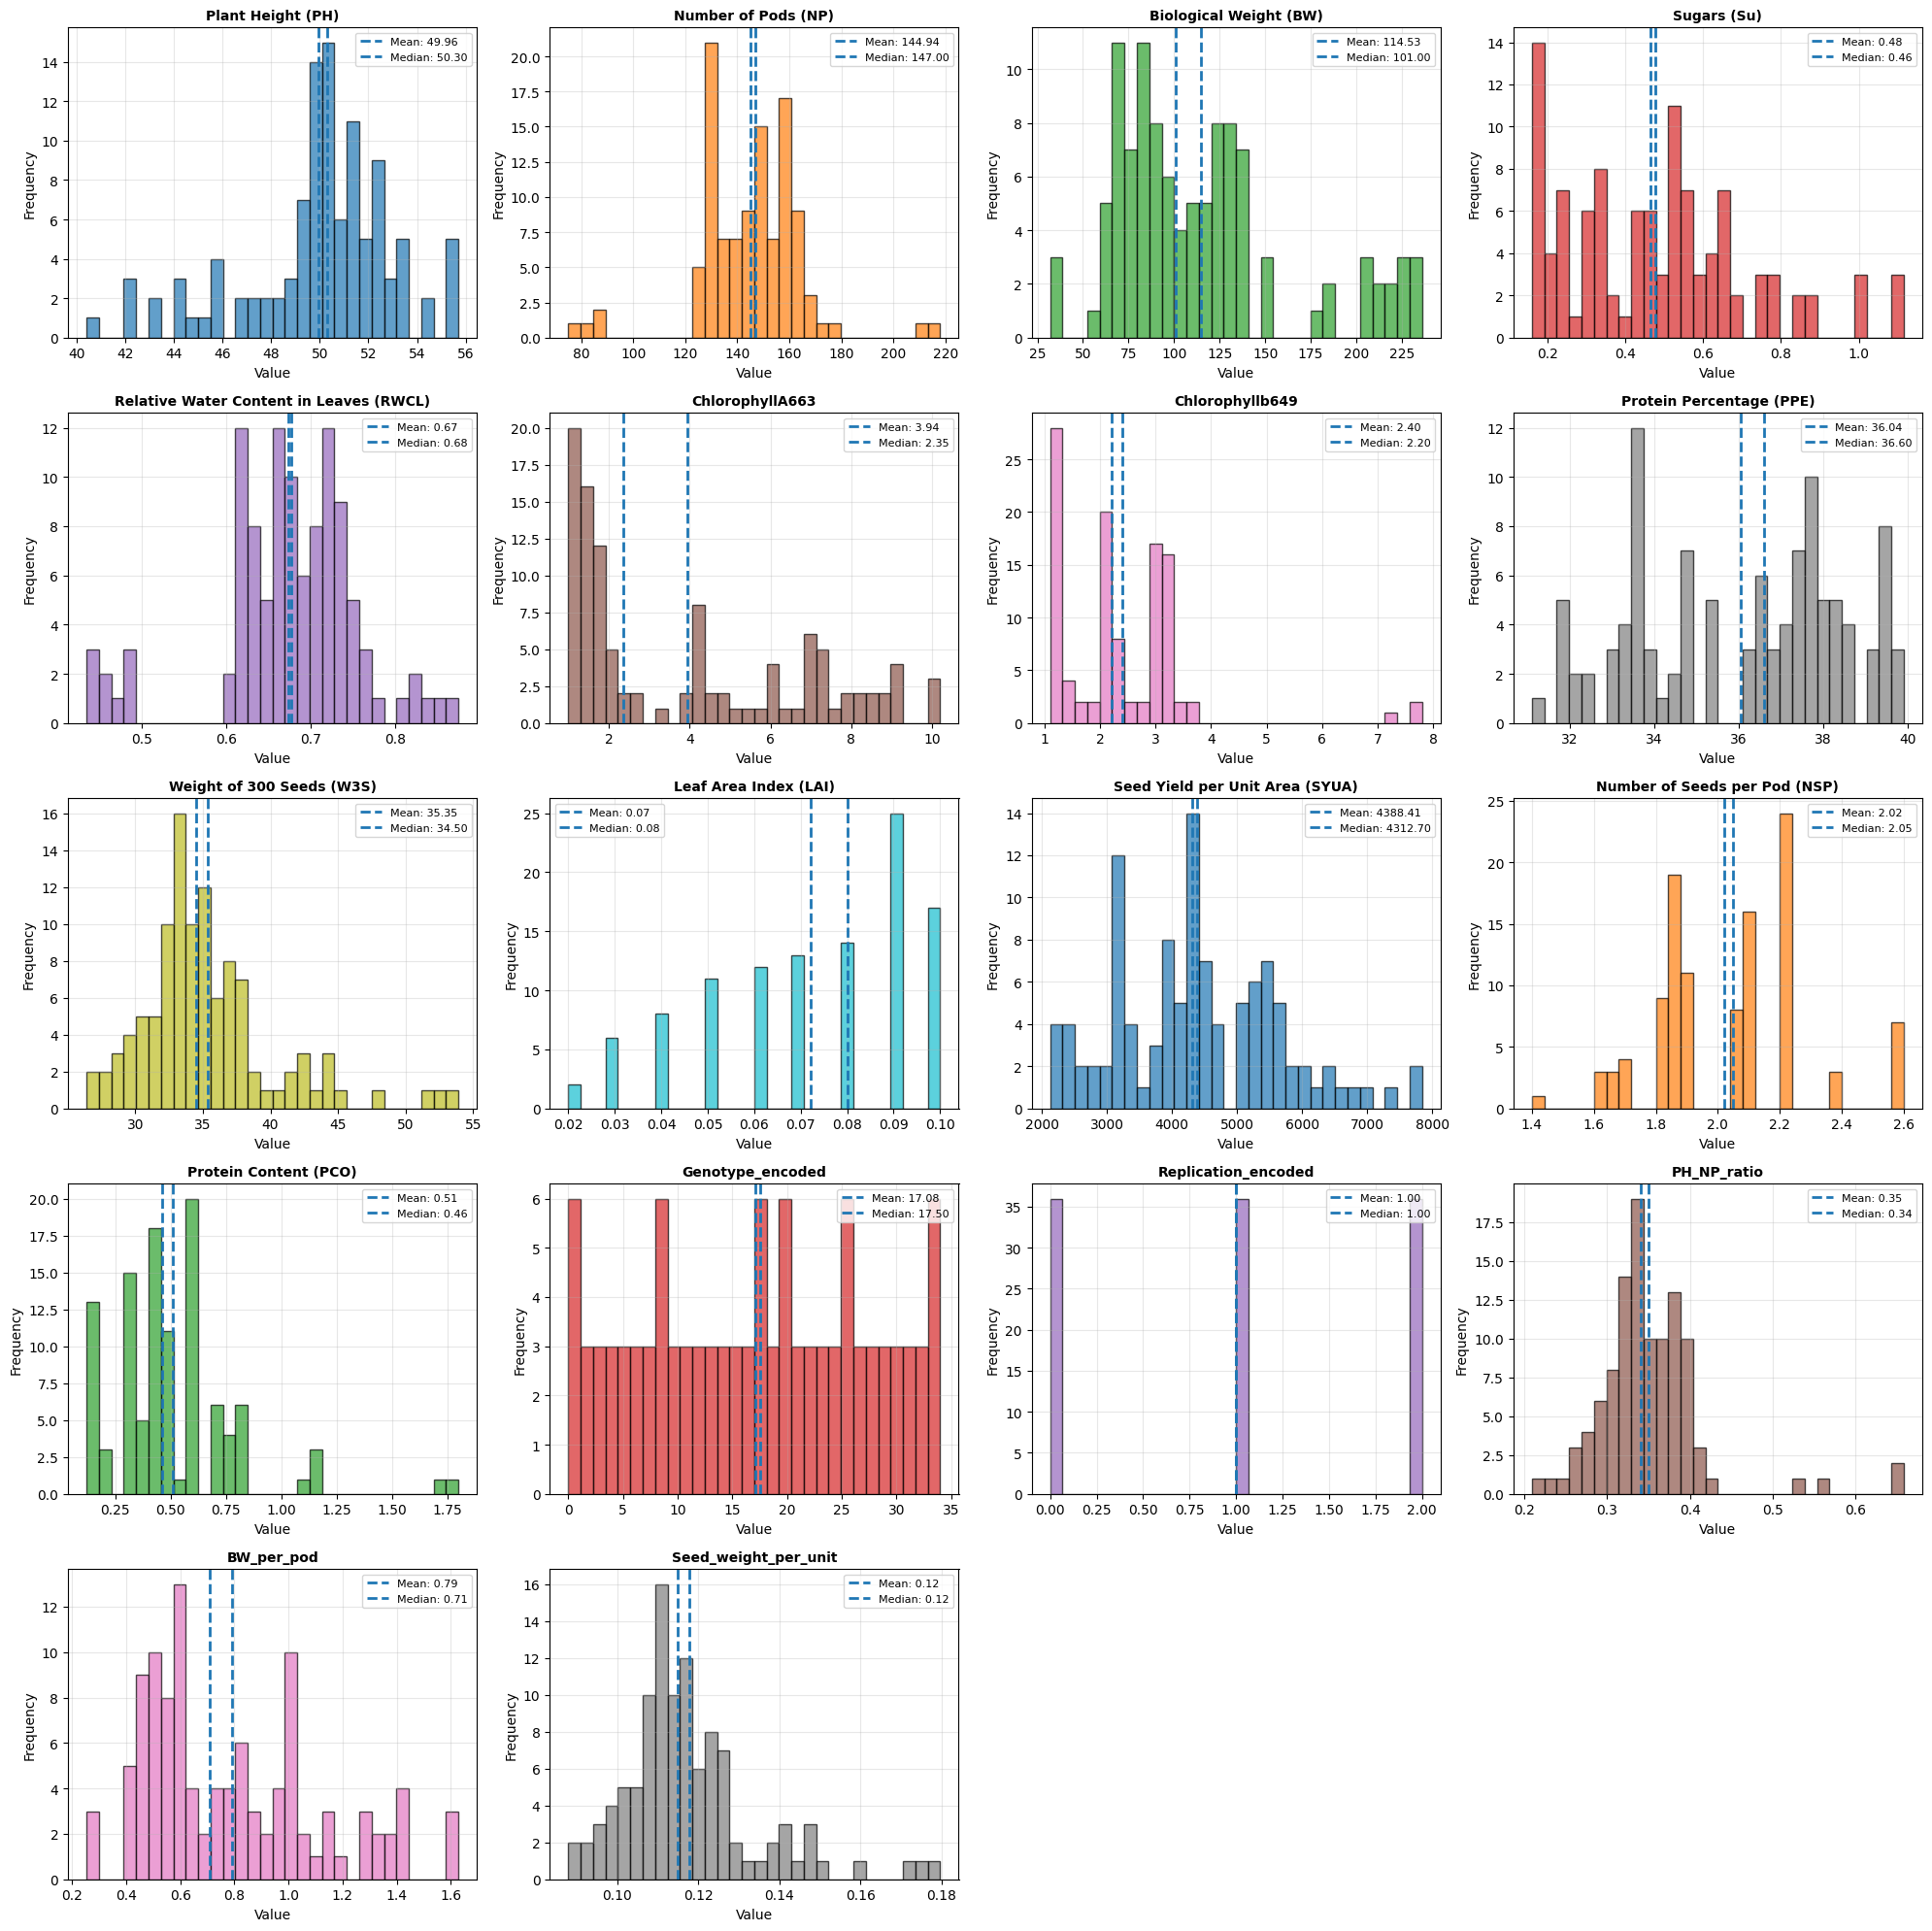

In [279]:
# 5.2 Distribution of All Numerical Features
print("\n5.2 Distribution of Numerical Features:")

numerical_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()

n_features = len(numerical_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    axes[idx].hist(
        df_processed[col].dropna(),
        bins=30,
        edgecolor='black',
        alpha=0.7,
        color=f'C{idx % 10}'
    )
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

    # Add statistics
    mean_val = df_processed[col].mean()
    median_val = df_processed[col].median()
    axes[idx].axvline(mean_val, linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[idx].legend(fontsize=8)

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



5.3 Correlation Analysis:


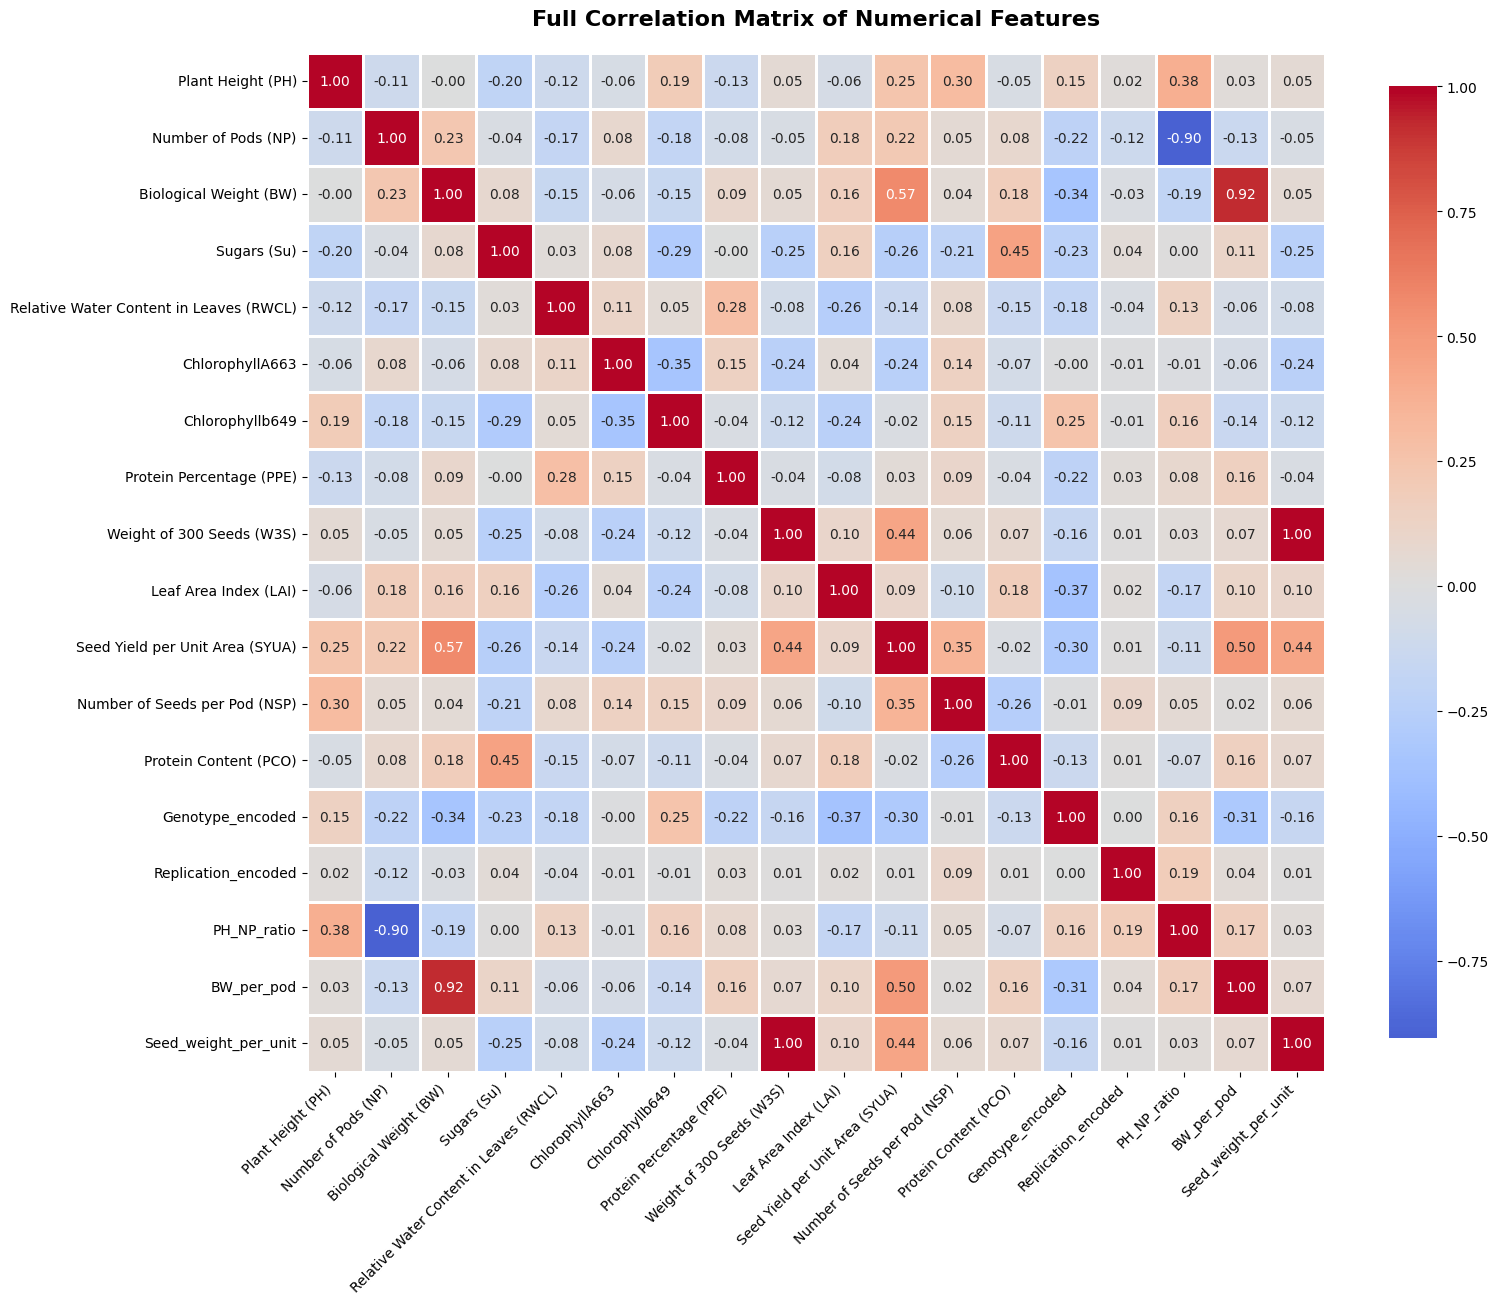

In [280]:
# 5.3 Correlation Analysis
print("\n5.3 Correlation Analysis:")

# Compute correlation matrix for numerical features
correlation_matrix = df_processed[numerical_features].corr()

# Plot full correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show correlation values
    fmt='.2f',           # 2 decimal places
    cmap='coolwarm',     # Color map
    center=0,            # Center the colormap at 0
    square=True,         # Make cells square
    linewidths=1,        # Lines between cells
    cbar_kws={"shrink": 0.8}  # Colorbar size
)
plt.title('Full Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



5.5 Box Plots for Outlier Detection:


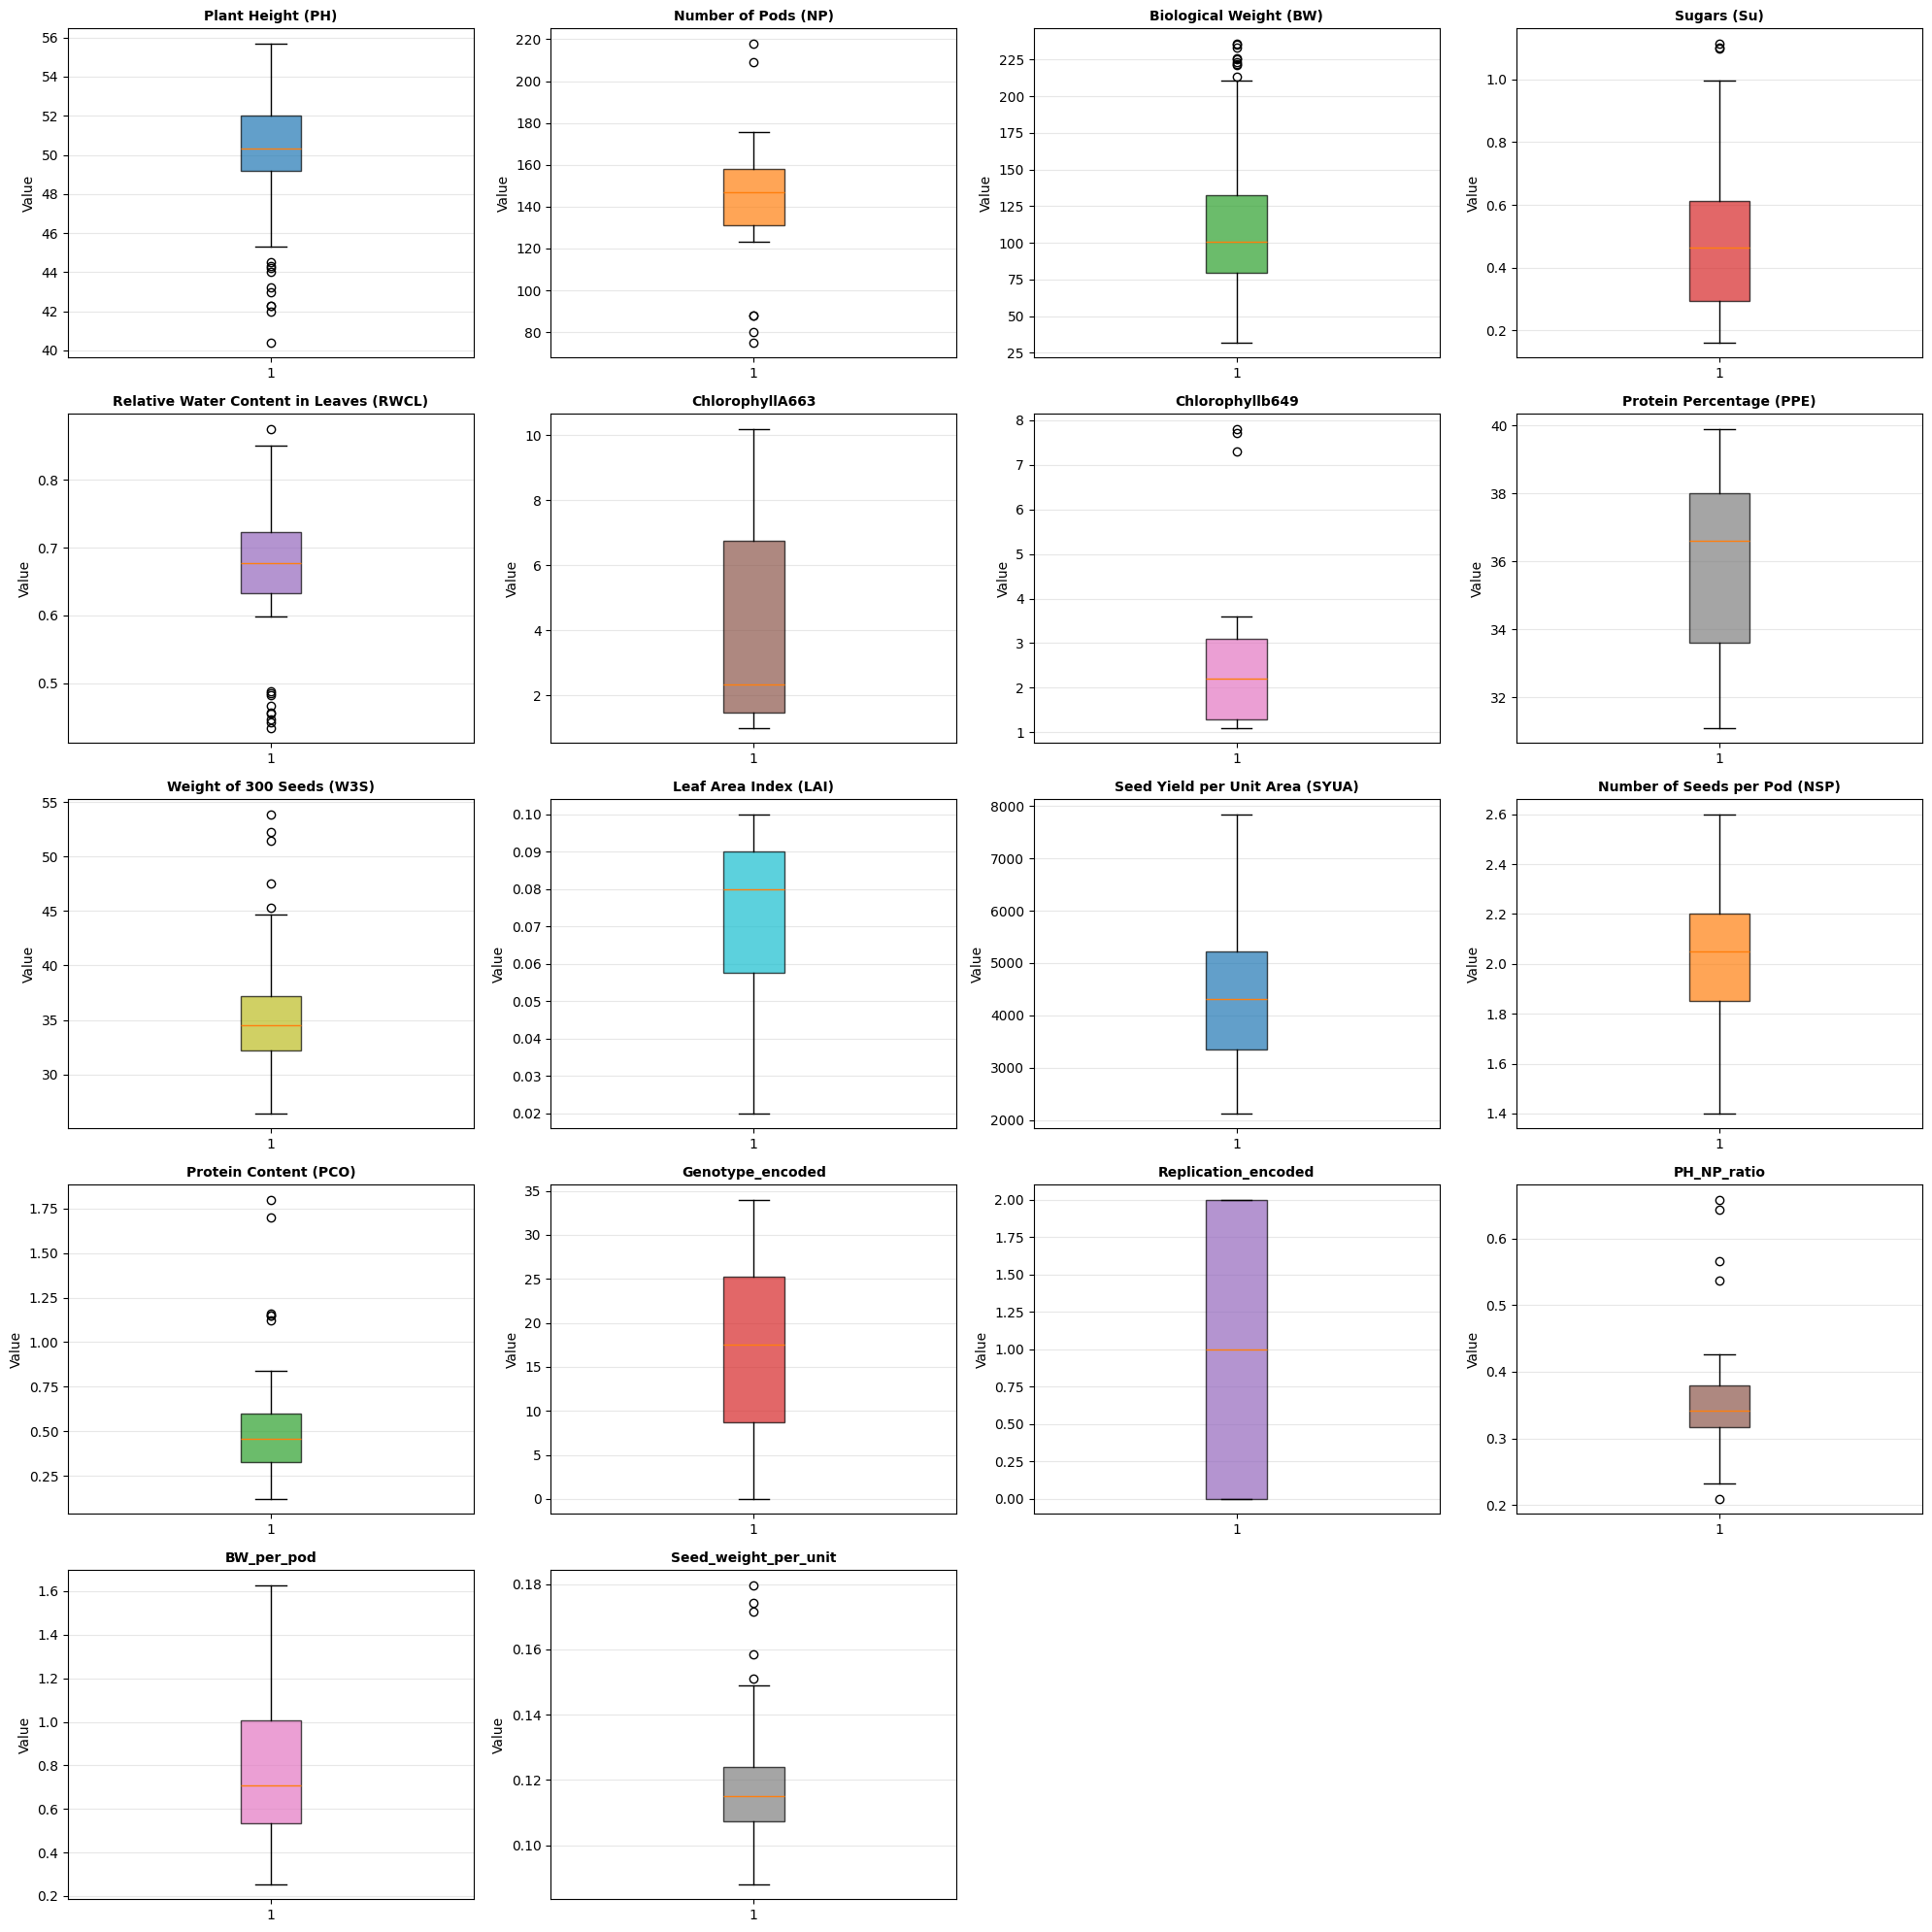

In [281]:
# 5.5 Box plots for outlier visualization
print("\n5.5 Box Plots for Outlier Detection:")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    bp = axes[idx].boxplot(
        df_processed[col].dropna(),
        vert=True,
        patch_artist=True
    )
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Color the box
    for patch in bp['boxes']:
        patch.set_facecolor(f'C{idx % 10}')
        patch.set_alpha(0.7)

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



5.6 Scatter Plots with Target Variable:


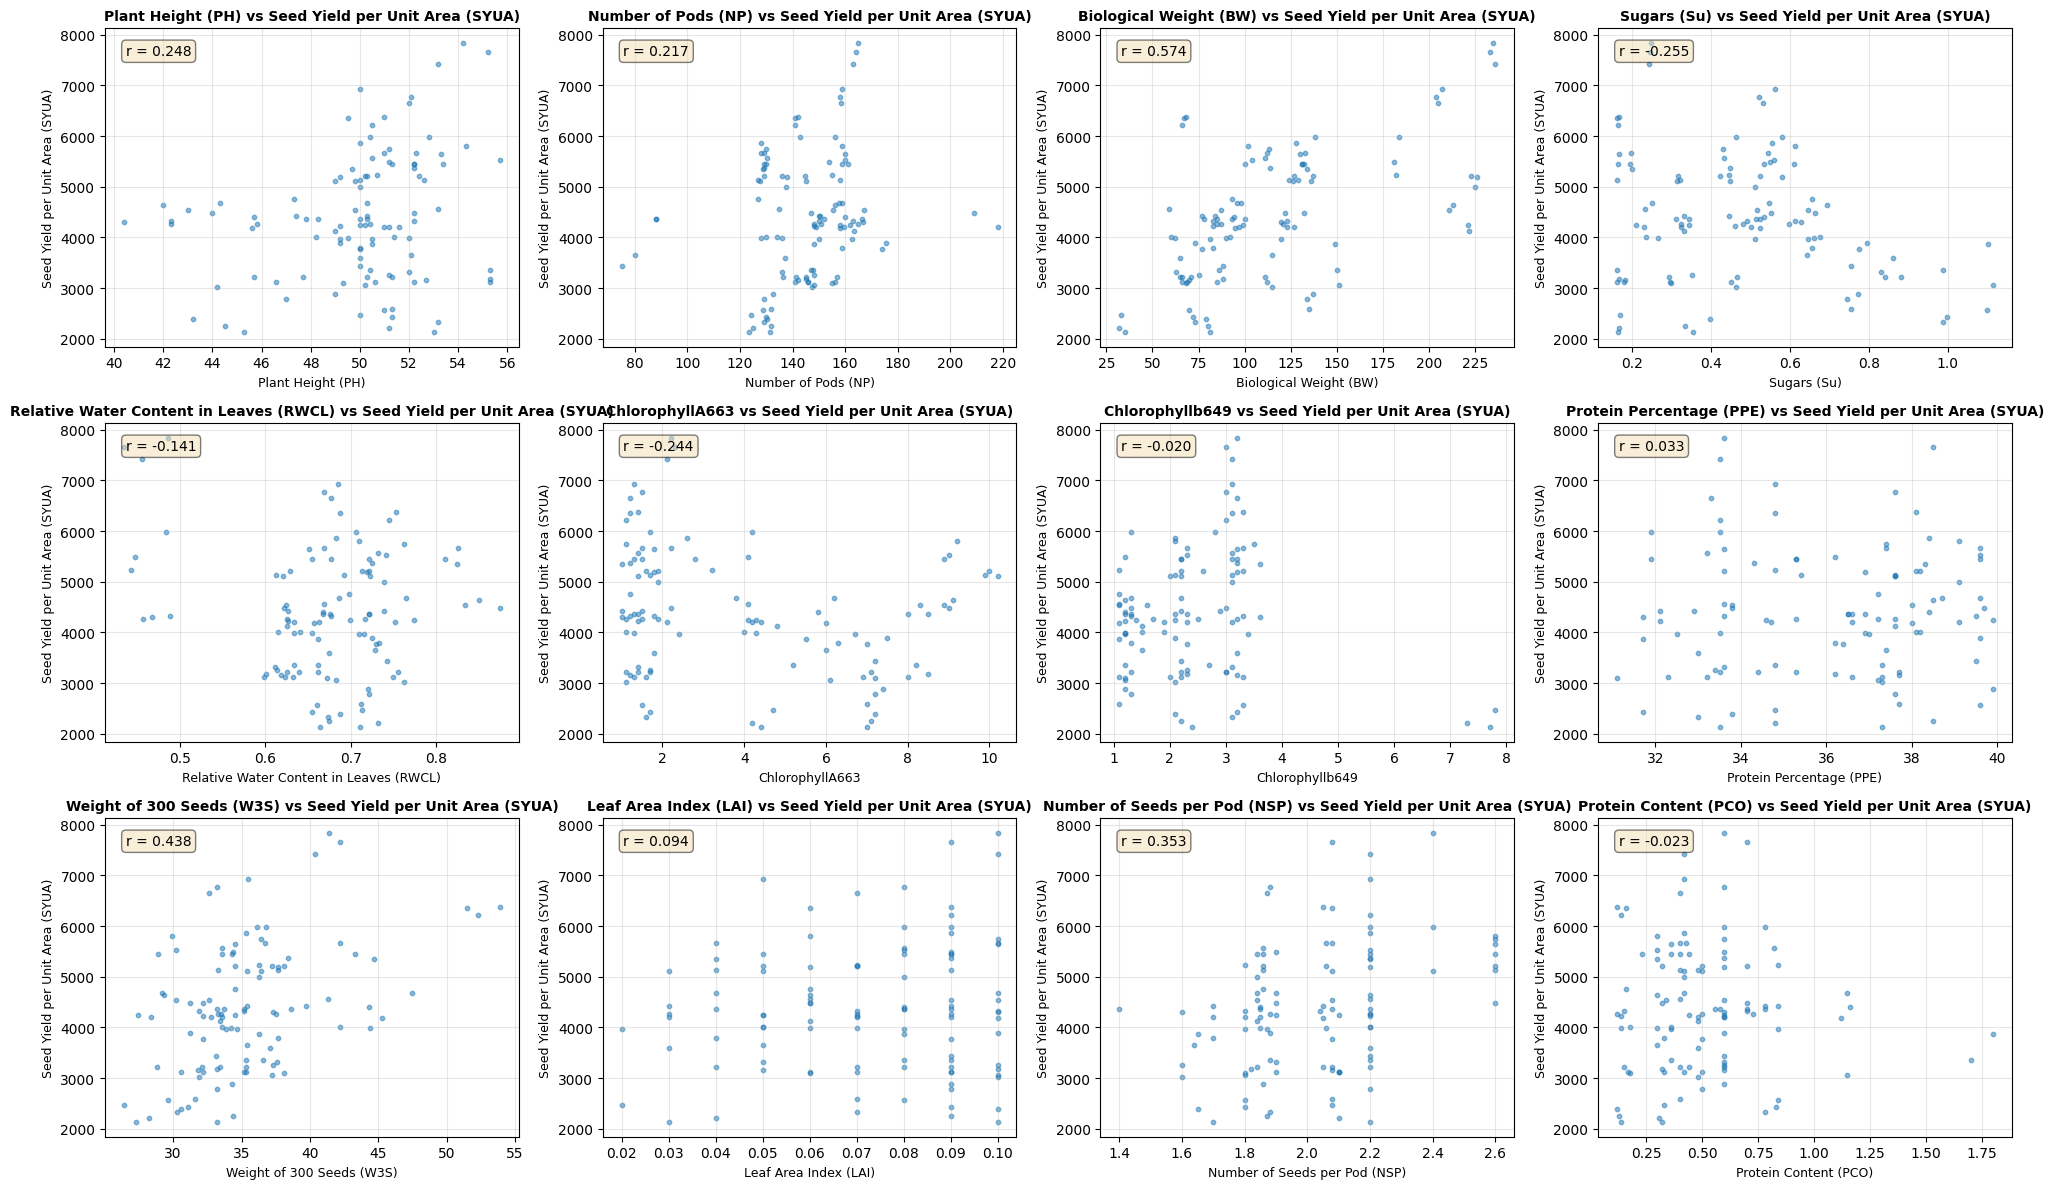

In [282]:
# 5.6 Scatter plots with target variable
print("\n5.6 Scatter Plots with Target Variable:")

if target_var in df_processed.columns:
    feature_list = [col for col in numerical_features if col != target_var][:12]

    n_features_scatter = len(feature_list)
    n_cols_scatter = 4
    n_rows_scatter = (n_features_scatter + n_cols_scatter - 1) // n_cols_scatter

    fig, axes = plt.subplots(
        n_rows_scatter,
        n_cols_scatter,
        figsize=(20, n_rows_scatter * 4)
    )
    axes = axes.flatten()

    for idx, col in enumerate(feature_list):
        axes[idx].scatter(
            df_processed[col],
            df_processed[target_var],
            alpha=0.5,
            s=10
        )
        axes[idx].set_xlabel(col, fontsize=9)
        axes[idx].set_ylabel(target_var, fontsize=9)
        axes[idx].set_title(f'{col} vs {target_var}', fontsize=10, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

        # Add correlation coefficient
        corr_val = df_processed[[col, target_var]].corr().iloc[0, 1]
        axes[idx].text(
            0.05,
            0.95,
            f'r = {corr_val:.3f}',
            transform=axes[idx].transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        )

    # Hide extra subplots
    for idx in range(n_features_scatter, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


In [283]:
# Define features and target
print("\n6.1 Feature and Target Selection:")
print("-" * 45)

# Get all numerical columns
all_numerical = df_processed.select_dtypes(include=[np.number]).columns.tolist()

# Remove target variable from features
X_columns = [col for col in all_numerical if col != target_var]
y_column = target_var

print(f"Target Variable: {y_column}")
print(f"Number of Features: {len(X_columns)}")
print(f"Features: {X_columns}")

# Prepare X and y
X = df_processed[X_columns].copy()
y = df_processed[y_column].copy()

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

# Check for any remaining NaN values
print(f"\nNaN values in X: {X.isnull().sum().sum()}")
print(f"NaN values in y: {y.isnull().sum()}")

# Remove any rows with NaN values
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    valid_indices = X.notna().all(axis=1) & y.notna()
    X = X[valid_indices]
    y = y[valid_indices]
    print(f"\nAfter removing NaN: X shape: {X.shape}, y shape: {y.shape}")

# 6.2 Train-Test Split
print("\n6.2 Train-Test Split:")
print("-" * 45)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]:,} ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]:,} ({(X_test.shape[0]/len(X))*100:.1f}%)")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

# 6.3 Feature Scaling
print("\n6.3 Feature Scaling:")
print("-" * 45)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_columns, index=X_test.index)



6.1 Feature and Target Selection:
---------------------------------------------
Target Variable: Seed Yield per Unit Area (SYUA)
Number of Features: 17
Features: ['Plant Height (PH)', 'Number of Pods (NP)', 'Biological Weight (BW)', 'Sugars (Su)', 'Relative Water Content in Leaves (RWCL)', 'ChlorophyllA663', 'Chlorophyllb649', 'Protein Percentage (PPE)', 'Weight of 300 Seeds (W3S)', 'Leaf Area Index (LAI)', 'Number of Seeds per Pod (NSP)', 'Protein Content (PCO)', 'Genotype_encoded', 'Replication_encoded', 'PH_NP_ratio', 'BW_per_pod', 'Seed_weight_per_unit']

X shape: (108, 17)
y shape: (108,)

NaN values in X: 0
NaN values in y: 0

6.2 Train-Test Split:
---------------------------------------------
Training set size: 86 (79.6%)
Test set size: 22 (20.4%)
Training features shape: (86, 17)
Test features shape: (22, 17)

6.3 Feature Scaling:
---------------------------------------------
Features scaled using StandardScaler
X_train_scaled shape: (86, 17)
X_test_scaled shape: (22, 17)


In [284]:

print("\n7.1 Building Neural Network Architecture:")


# Define neural network architecture using MLPRegressor
nn_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    verbose=True
)

print("Neural Network Architecture:")
print("Hidden Layers: (128, 64, 32, 16)")
print("Activation: ReLU")
print("Solver: Adam")
print("Learning Rate: 0.001 (adaptive)")
print("Max Iterations: 500")
print("Early Stopping: Enabled (patience=20)")

print("\n7.2 Training Neural Network:")


# Train the model
nn_model.fit(X_train_scaled, y_train)

print(f"\nTraining completed in {nn_model.n_iter_} iterations")
print(f"Final training loss: {nn_model.loss_:.4f}")

print("\n7.3 Neural Network Training History:")





7.1 Building Neural Network Architecture:
Neural Network Architecture:
Hidden Layers: (128, 64, 32, 16)
Activation: ReLU
Solver: Adam
Learning Rate: 0.001 (adaptive)
Max Iterations: 500
Early Stopping: Enabled (patience=20)

7.2 Training Neural Network:
Iteration 1, loss = 10644738.25333694
Validation score: -15.443516
Iteration 2, loss = 10644110.61893257
Validation score: -15.442848
Iteration 3, loss = 10643595.46587241
Validation score: -15.442153
Iteration 4, loss = 10643107.22965519
Validation score: -15.441432
Iteration 5, loss = 10642563.07307015
Validation score: -15.440586
Iteration 6, loss = 10641911.41152022
Validation score: -15.439521
Iteration 7, loss = 10641110.82161135
Validation score: -15.438171
Iteration 8, loss = 10640078.90242577
Validation score: -15.436428
Iteration 9, loss = 10638662.79965260
Validation score: -15.434040
Iteration 10, loss = 10636797.75047731
Validation score: -15.430836
Iteration 11, loss = 10634196.06478528
Validation score: -15.426632
Iterat

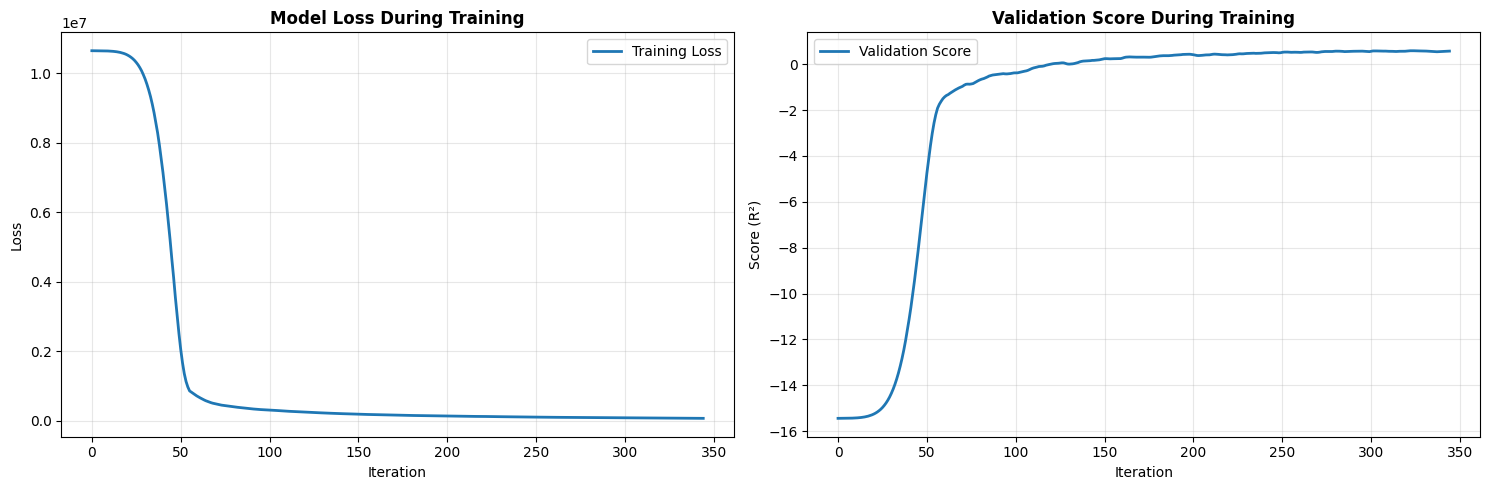

In [285]:
# Plot training history
if hasattr(nn_model, 'loss_curve_') and hasattr(nn_model, 'validation_scores_'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(nn_model.loss_curve_, label='Training Loss', linewidth=2)
    axes[0].set_title('Model Loss During Training', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Validation score plot
    axes[1].plot(nn_model.validation_scores_, label='Validation Score', linewidth=2)
    axes[1].set_title('Validation Score During Training', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Score (R²)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for plotting")


In [286]:
print("\n7.4 Neural Network Evaluation:")
print("-" * 40)
# Predictions
y_train_pred_nn = nn_model.predict(X_train_scaled)
y_test_pred_nn = nn_model.predict(X_test_scaled)

# Calculate metrics
nn_train_mse = mean_squared_error(y_train, y_train_pred_nn)
nn_train_rmse = np.sqrt(nn_train_mse)
nn_train_mae = mean_absolute_error(y_train, y_train_pred_nn)
nn_train_r2 = r2_score(y_train, y_train_pred_nn)

nn_test_mse = mean_squared_error(y_test, y_test_pred_nn)
nn_test_rmse = np.sqrt(nn_test_mse)
nn_test_mae = mean_absolute_error(y_test, y_test_pred_nn)
nn_test_r2 = r2_score(y_test, y_test_pred_nn)

print("Training Set Performance:")
print(f"  MSE:  {nn_train_mse:,.2f}")
print(f"  RMSE: {nn_train_rmse:,.2f}")
print(f"  MAE:  {nn_train_mae:,.2f}")
print(f"  R²:   {nn_train_r2:.4f}")

print("\nTest Set Performance:")
print(f"  MSE:  {nn_test_mse:,.2f}")
print(f"  RMSE: {nn_test_rmse:,.2f}")
print(f"  MAE:  {nn_test_mae:,.2f}")
print(f"  R²:   {nn_test_r2:.4f}")






7.4 Neural Network Evaluation:
----------------------------------------
Training Set Performance:
  MSE:  219,900.36
  RMSE: 468.94
  MAE:  335.43
  R²:   0.8681

Test Set Performance:
  MSE:  838,887.98
  RMSE: 915.91
  MAE:  734.82
  R²:   0.2734


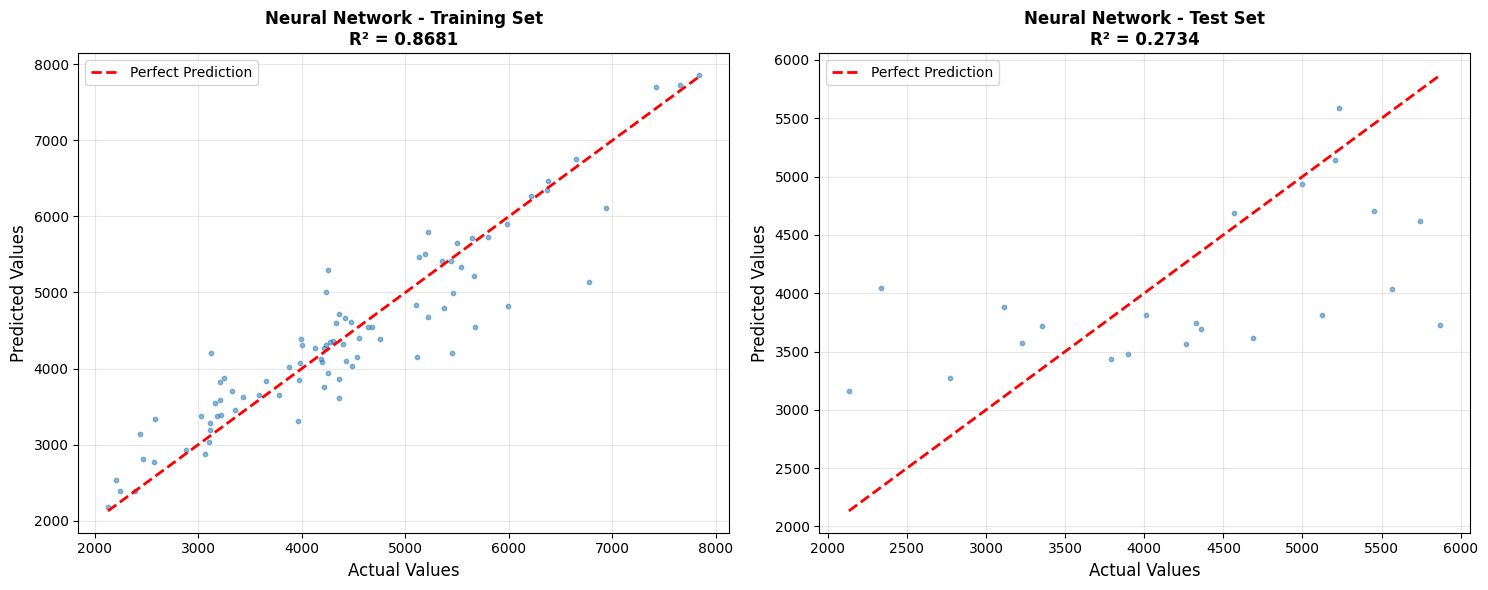

In [287]:
# Prediction vs Actual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_nn, alpha=0.5, s=10)
axes[0].plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    'r--',
    lw=2,
    label='Perfect Prediction'
)
axes[0].set_xlabel('Actual Values', fontsize=12)
axes[0].set_ylabel('Predicted Values', fontsize=12)
axes[0].set_title(
    f'Neural Network - Training Set\nR² = {nn_train_r2:.4f}',
    fontsize=12,
    fontweight='bold'
)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_nn, alpha=0.5, s=10)
axes[1].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    lw=2,
    label='Perfect Prediction'
)
axes[1].set_xlabel('Actual Values', fontsize=12)
axes[1].set_ylabel('Predicted Values', fontsize=12)
axes[1].set_title(
    f'Neural Network - Test Set\nR² = {nn_test_r2:.4f}',
    fontsize=12,
    fontweight='bold'
)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


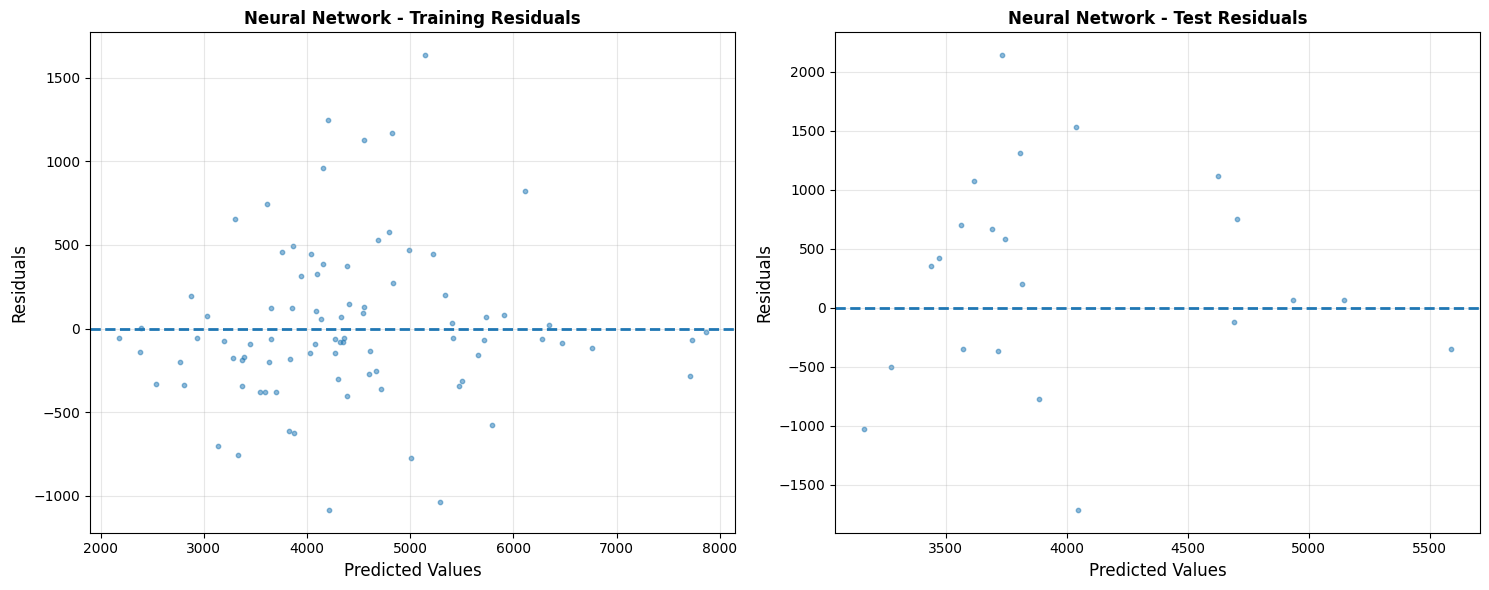

In [288]:
# Residual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training residuals
train_residuals_nn = y_train - y_train_pred_nn
axes[0].scatter(y_train_pred_nn, train_residuals_nn, alpha=0.5, s=10)
axes[0].axhline(y=0, linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Neural Network - Training Residuals', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test residuals
test_residuals_nn = y_test - y_test_pred_nn
axes[1].scatter(y_test_pred_nn, test_residuals_nn, alpha=0.5, s=10)
axes[1].axhline(y=0, linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Neural Network - Test Residuals', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [289]:
# Initialize models
models_dict = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Regression': SVR()
}


In [290]:
# Dictionary to store results
model_results = {}

print("\n8.1 Training Classical ML Models:")
print("-" * 40)

for name, model in models_dict.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Store results
    model_results[name] = {
        'model': model,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

    print(f"  Training R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"  Training RMSE: {train_rmse:,.2f}, Test RMSE: {test_rmse:,.2f}")

print("\n8.2 Model Performance Comparison:")
print("-" * 40)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train_MSE': [model_results[m]['train_mse'] for m in model_results.keys()],
    'Train_RMSE': [model_results[m]['train_rmse'] for m in model_results.keys()],
    'Train_MAE': [model_results[m]['train_mae'] for m in model_results.keys()],
    'Train_R2': [model_results[m]['train_r2'] for m in model_results.keys()],
    'Test_MSE': [model_results[m]['test_mse'] for m in model_results.keys()],
    'Test_RMSE': [model_results[m]['test_rmse'] for m in model_results.keys()],
    'Test_MAE': [model_results[m]['test_mae'] for m in model_results.keys()],
    'Test_R2': [model_results[m]['test_r2'] for m in model_results.keys()]
})

print(comparison_df.to_string(index=False))


8.1 Training Classical ML Models:
----------------------------------------

Training Linear Regression...
  Training R²: 0.7235, Test R²: 0.3785
  Training RMSE: 678.98, Test RMSE: 847.07

Training Random Forest...
  Training R²: 0.9637, Test R²: 0.6580
  Training RMSE: 246.00, Test RMSE: 628.36

Training Gradient Boosting...
  Training R²: 0.9988, Test R²: 0.7808
  Training RMSE: 44.15, Test RMSE: 503.06

Training Decision Tree...
  Training R²: 1.0000, Test R²: 0.3951
  Training RMSE: 0.00, Test RMSE: 835.72

Training Support Vector Regression...
  Training R²: -0.0070, Test R²: 0.0022
  Training RMSE: 1,295.69, Test RMSE: 1,073.34

8.2 Model Performance Comparison:
----------------------------------------
                    Model    Train_MSE  Train_RMSE   Train_MAE  Train_R2     Test_MSE   Test_RMSE   Test_MAE  Test_R2
        Linear Regression 4.610122e+05  678.978789  558.730750  0.723471 7.175233e+05  847.067481 704.408696 0.378547
            Random Forest 6.051483e+04  245.9

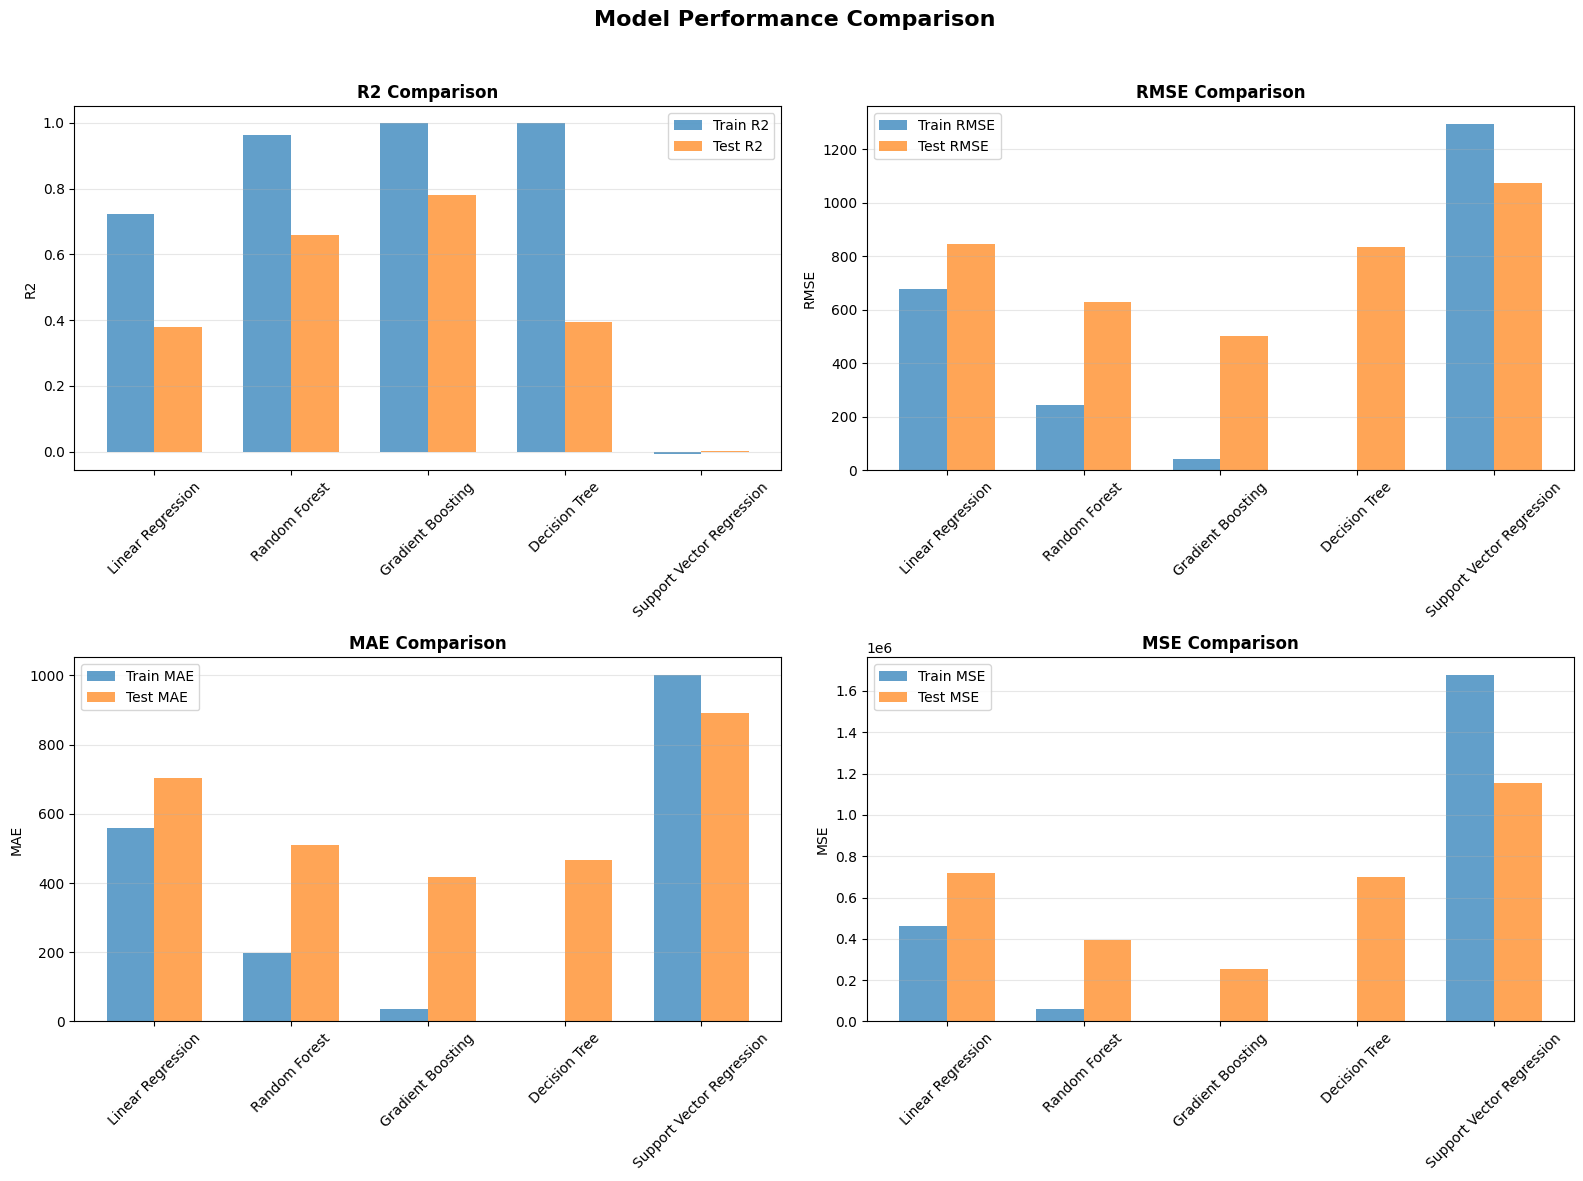


Top 2 models selected for optimization: ['Gradient Boosting', 'Random Forest']


In [311]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics
metrics = ['R2', 'RMSE', 'MAE', 'MSE']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

width = 0.35  # width of the bars

for ax, metric in zip(axes, metrics):
    train_col = f'Train_{metric}'
    test_col = f'Test_{metric}'

    models = comparison_df['Model'].tolist()
    x = np.arange(len(models))  # label locations

    # Grouped bars
    ax.bar(x - width/2, comparison_df[train_col], width, label=f'Train {metric}', alpha=0.7)
    ax.bar(x + width/2, comparison_df[test_col], width, label=f'Test {metric}', alpha=0.7)

    # Labels, title, grid
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

# Select top 2 models based on Test R2
top_2_models = comparison_df.nlargest(2, 'Test_R2')['Model'].tolist()
print(f"\nTop 2 models selected for optimization: {top_2_models}")


In [292]:
# Define parameter grids for top 2 models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Linear Regression': {
        # Linear Regression has no hyperparameters, use Ridge instead
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'Decision Tree': {
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None]
    },
    'Support Vector Regression': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'epsilon': [0.01, 0.1, 0.2],
        'kernel': ['rbf', 'linear']
    }
}

In [293]:
# Optimize top 2 models
optimized_models = {}
cv_results = {}

for idx, model_name in enumerate(top_2_models, start=1):
    print(f"\n9.{idx} Optimizing {model_name}:")
    print("-" * 40)

    # Select base model and parameter grid
    if model_name == 'Linear Regression':
        base_model = Ridge(random_state=42)
        param_grid = param_grids.get('Linear Regression', {})
    else:
        base_model = model_results[model_name]['model']
        param_grid = param_grids.get(model_name, {})

    if not param_grid:
        print(f"  No parameter grid defined for {model_name}, skipping optimization...")
        continue

    print(f"  Parameter grid: {param_grid}")

    # GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    print("  Running GridSearchCV...")
    grid_search.fit(X_train_scaled, y_train)

    # Best model and CV results
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"  Best parameters: {best_params}")
    print(f"  Best CV R² score: {best_score:.4f}")

    # Store results
    optimized_models[model_name] = best_model
    cv_results[model_name] = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'cv_results': grid_search.cv_results_
    }

# Summary
print("\n9.3 Cross-Validation Results Summary:")
print("-" * 40)
for model_name, results in cv_results.items():
    print(f"\n{model_name}:")
    print(f"  Best CV Score (R²): {results['best_cv_score']:.4f}")
    print(f"  Best Parameters: {results['best_params']}")



9.1 Optimizing Gradient Boosting:
----------------------------------------
  Parameter grid: {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'subsample': [0.8, 0.9, 1.0]}
  Running GridSearchCV...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
  Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.9}
  Best CV R² score: 0.7775

9.2 Optimizing Random Forest:
----------------------------------------
  Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2']}
  Running GridSearchCV...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
  Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_


10.1 Feature Importance Analysis:

Gradient Boosting - Top 10 Features:
                      Feature  Importance
       Biological Weight (BW)    0.262058
             Genotype_encoded    0.114313
         Seed_weight_per_unit    0.107999
          Number of Pods (NP)    0.075855
              ChlorophyllA663    0.072043
    Weight of 300 Seeds (W3S)    0.071866
Number of Seeds per Pod (NSP)    0.064140
                  Sugars (Su)    0.061957
                   BW_per_pod    0.056827
              Chlorophyllb649    0.038464

Random Forest - Top 10 Features:
                      Feature  Importance
       Biological Weight (BW)    0.150976
    Weight of 300 Seeds (W3S)    0.097666
             Genotype_encoded    0.093798
                   BW_per_pod    0.091396
         Seed_weight_per_unit    0.083413
          Number of Pods (NP)    0.075772
            Plant Height (PH)    0.065263
                  Sugars (Su)    0.058819
              ChlorophyllA663    0.054739
Number of S

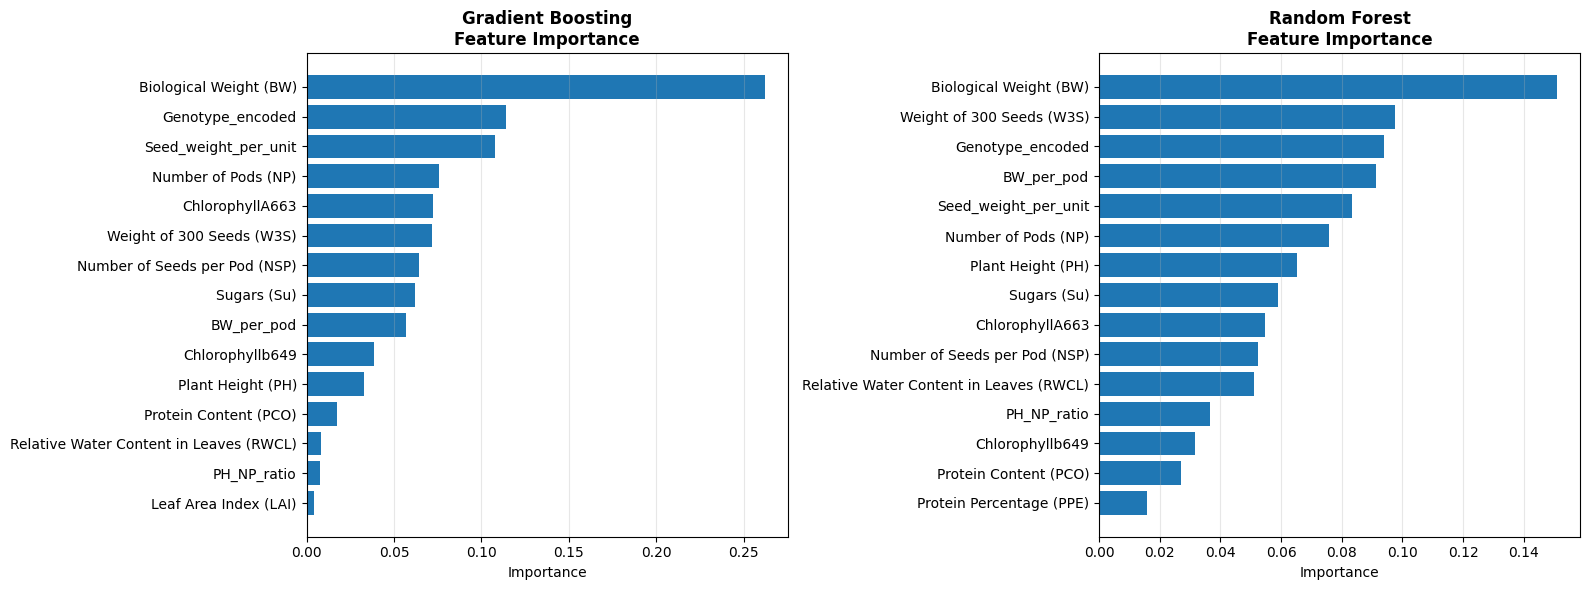


10.2 SelectKBest Feature Selection:


In [294]:
print("\n10.1 Feature Importance Analysis:")

# Feature importance from tree-based models
feature_importance_dict = {}

for model_name in optimized_models.keys():
    if hasattr(optimized_models[model_name], 'feature_importances_'):
        importance = optimized_models[model_name].feature_importances_
        feature_importance_dict[model_name] = pd.DataFrame({
            'Feature': X_columns,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        print(f"\n{model_name} - Top 10 Features:")
        print(feature_importance_dict[model_name].head(10).to_string(index=False))

# Plot feature importance (display only, no saving)
if feature_importance_dict:
    n_models = len(feature_importance_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 6))

    if n_models == 1:
        axes = [axes]

    for idx, (model_name, importance_df) in enumerate(feature_importance_dict.items()):
        top_features = importance_df.head(15)
        axes[idx].barh(range(len(top_features)), top_features['Importance'])
        axes[idx].set_yticks(range(len(top_features)))
        axes[idx].set_yticklabels(top_features['Feature'])
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{model_name}\nFeature Importance', fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

print("\n10.2 SelectKBest Feature Selection:")


In [295]:
# Use SelectKBest with f_regression
k_best = min(10, len(X_columns))
selector = SelectKBest(score_func=f_regression, k=k_best)
selector.fit(X_train_scaled, y_train)

# Get selected feature indices
selected_indices = selector.get_support(indices=True)
selected_features_kbest = [X_columns[i] for i in selected_indices]

# Get scores
feature_scores = pd.DataFrame({
    'Feature': X_columns,
    'F_Score': selector.scores_,
    'P_Value': selector.pvalues_
}).sort_values('F_Score', ascending=False)

print(f"Selected {k_best} best features:")
print(feature_scores.head(k_best).to_string(index=False))



Selected 10 best features:
                      Feature   F_Score      P_Value
       Biological Weight (BW) 41.065312 8.138234e-09
                   BW_per_pod 25.941376 2.128063e-06
         Seed_weight_per_unit 22.147678 9.836859e-06
    Weight of 300 Seeds (W3S) 22.147678 9.836859e-06
Number of Seeds per Pod (NSP) 16.890051 9.171240e-05
            Plant Height (PH) 10.609765 1.623786e-03
             Genotype_encoded  8.215131 5.248759e-03
              ChlorophyllA663  5.962148 1.671478e-02
                  Sugars (Su)  5.634439 1.989223e-02
          Number of Pods (NP)  5.518037 2.116916e-02


In [296]:
print("\n10.3 Recursive Feature Elimination (RFE):")

# Use RFE with one of the optimized models
if optimized_models:
    rfe_model_name = list(optimized_models.keys())[0]
    rfe_model = optimized_models[rfe_model_name]

    rfe = RFE(estimator=rfe_model, n_features_to_select=k_best, step=1)
    rfe.fit(X_train_scaled, y_train)

    selected_features_rfe = [X_columns[i] for i in range(len(X_columns)) if rfe.support_[i]]

    rfe_ranking = pd.DataFrame({
        'Feature': X_columns,
        'Ranking': rfe.ranking_,
        'Selected': rfe.support_
    }).sort_values('Ranking')

    print(f"RFE using {rfe_model_name}:")
    print(rfe_ranking.to_string(index=False))


10.3 Recursive Feature Elimination (RFE):
RFE using Gradient Boosting:
                                Feature  Ranking  Selected
                      Plant Height (PH)        1      True
                    Number of Pods (NP)        1      True
                 Biological Weight (BW)        1      True
                            Sugars (Su)        1      True
                        ChlorophyllA663        1      True
                             BW_per_pod        1      True
          Number of Seeds per Pod (NSP)        1      True
              Weight of 300 Seeds (W3S)        1      True
                       Genotype_encoded        1      True
                   Seed_weight_per_unit        1      True
                        Chlorophyllb649        2     False
                  Protein Content (PCO)        3     False
Relative Water Content in Leaves (RWCL)        4     False
                            PH_NP_ratio        5     False
                  Leaf Area Index (LAI)    

In [297]:
print("\n10.4 Mutual Information Feature Selection:")

# Calculate mutual information
mi_scores = mutual_info_regression(X_train_scaled, y_train, random_state=42)

mi_df = pd.DataFrame({
    'Feature': X_columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Mutual Information Scores:")
print(mi_df.to_string(index=False))


10.4 Mutual Information Feature Selection:
Mutual Information Scores:
                                Feature  MI_Score
                    Number of Pods (NP)  0.484202
                       Genotype_encoded  0.383887
                 Biological Weight (BW)  0.375169
                            PH_NP_ratio  0.345038
                             BW_per_pod  0.307094
                            Sugars (Su)  0.280146
Relative Water Content in Leaves (RWCL)  0.229866
                        ChlorophyllA663  0.213346
                        Chlorophyllb649  0.132350
                      Plant Height (PH)  0.115293
                   Seed_weight_per_unit  0.110351
              Weight of 300 Seeds (W3S)  0.105531
                  Protein Content (PCO)  0.014484
               Protein Percentage (PPE)  0.000000
          Number of Seeds per Pod (NSP)  0.000000
                  Leaf Area Index (LAI)  0.000000
                    Replication_encoded  0.000000


In [298]:
# Select top features based on MI
selected_features_mi = mi_df.head(k_best)['Feature'].tolist()

# Combine feature selection results
print("\n10.5 Combined Feature Selection Summary:")

# Find common features across methods
all_selected = {
    'SelectKBest': set(selected_features_kbest),
    'RFE': set(selected_features_rfe) if 'selected_features_rfe' in locals() else set(),
    'MutualInfo': set(selected_features_mi)
}


10.5 Combined Feature Selection Summary:


In [299]:
# Features selected by at least 2 methods
common_features = set.intersection(*[s for s in all_selected.values() if s])

if not common_features:
    # If no common features, take union of top features
    common_features = set.union(*[s for s in all_selected.values() if s])

final_selected_features = list(common_features)[:k_best]

print(f"Features selected by multiple methods: {final_selected_features}")
print(f"Total selected features: {len(final_selected_features)}")


Features selected by multiple methods: ['BW_per_pod', 'Number of Pods (NP)', 'Genotype_encoded', 'Plant Height (PH)', 'Biological Weight (BW)', 'ChlorophyllA663', 'Sugars (Su)']
Total selected features: 7


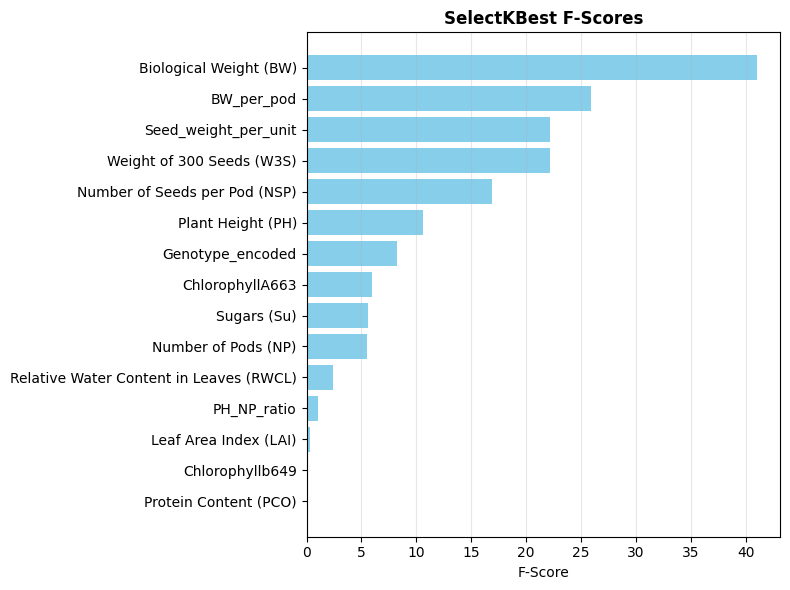

In [300]:
# Visualize SelectKBest feature selection
top_kbest = feature_scores.head(15)

plt.figure(figsize=(8, 6))
plt.barh(range(len(top_kbest)), top_kbest['F_Score'], color='skyblue')
plt.yticks(range(len(top_kbest)), top_kbest['Feature'])
plt.xlabel('F-Score')
plt.title('SelectKBest F-Scores', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [301]:
# RFE ranking
if 'rfe_ranking' in locals():
    top_rfe = rfe_ranking.head(15)
    axes[1].barh(range(len(top_rfe)), top_rfe['Ranking'])
    axes[1].set_yticks(range(len(top_rfe)))
    axes[1].set_yticklabels(top_rfe['Feature'])
    axes[1].set_xlabel('Ranking (1=best)')
    axes[1].set_title('RFE Ranking', fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')

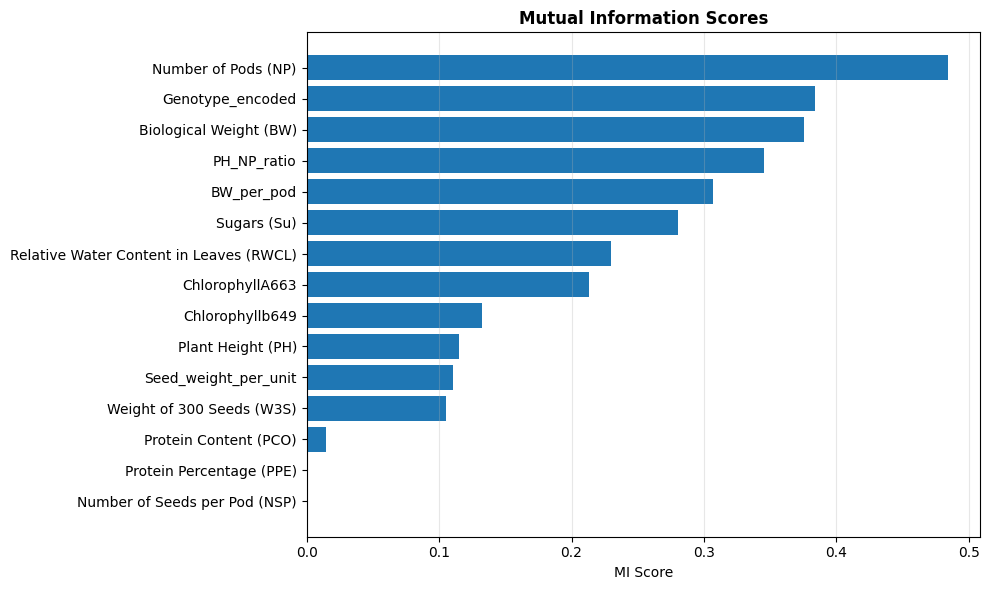

In [302]:
# Mutual Information scores
top_mi = mi_df.head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(top_mi)), top_mi['MI_Score'])
ax.set_yticks(range(len(top_mi)))
ax.set_yticklabels(top_mi['Feature'])
ax.set_xlabel('MI Score')
ax.set_title('Mutual Information Scores', fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [303]:
# Prepare data with selected features
X_train_selected = X_train_scaled_df[final_selected_features]
X_test_selected = X_test_scaled_df[final_selected_features]

print(f"\n11.1 Training Final Models with {len(final_selected_features)} Selected Features:")
print("-" * 40)
print(f"Selected Features: {final_selected_features}")

final_model_results = {}

for model_name in optimized_models.keys():
    print(f"\nTraining {model_name} with selected features...")

    model = optimized_models[model_name]

    # Train on selected features
    model.fit(X_train_selected, y_train)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='r2')
    cv_score_mean = cv_scores.mean()
    cv_score_std = cv_scores.std()

    # Predictions
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Store results
    final_model_results[model_name] = {
        'model': model,
        'cv_score_mean': cv_score_mean,
        'cv_score_std': cv_score_std,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'features_used': len(final_selected_features),
        'best_params': cv_results[model_name]['best_params']
    }

    print(f"  CV R² Score: {cv_score_mean:.4f} (+/- {cv_score_std:.4f})")
    print(f"  Test R² Score: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:,.2f}")



11.1 Training Final Models with 7 Selected Features:
----------------------------------------
Selected Features: ['BW_per_pod', 'Number of Pods (NP)', 'Genotype_encoded', 'Plant Height (PH)', 'Biological Weight (BW)', 'ChlorophyllA663', 'Sugars (Su)']

Training Gradient Boosting with selected features...
  CV R² Score: 0.7090 (+/- 0.1697)
  Test R² Score: 0.8400
  Test RMSE: 429.80

Training Random Forest with selected features...
  CV R² Score: 0.6900 (+/- 0.1207)
  Test R² Score: 0.7310
  Test RMSE: 557.30


In [304]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use only the selected features
X_train_selected = X_train_scaled_df[final_selected_features]
X_test_selected = X_test_scaled_df[final_selected_features]

print(f"\n11.1 Training Final Models with {len(final_selected_features)} Selected Features:")
print("-" * 40)
print(f"Selected Features: {final_selected_features}")

final_model_results = {}

for model_name, model in optimized_models.items():
    print(f"\nTraining {model_name} with selected features...")

    # Train model on selected features
    model.fit(X_train_selected, y_train)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='r2')
    cv_score_mean = cv_scores.mean()
    cv_score_std = cv_scores.std()

    # Predictions
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    # Metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Store results
    final_model_results[model_name] = {
        'features_used': final_selected_features,
        'cv_score_mean': cv_score_mean,
        'cv_score_std': cv_score_std,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'best_params': cv_results[model_name]['best_params']
    }

    print(f"  CV R² Score: {cv_score_mean:.4f} (+/- {cv_score_std:.4f})")
    print(f"  Train R² Score: {train_r2:.4f}")
    print(f"  Test R² Score: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:,.2f}")
    print(f"  Test MAE: {test_mae:,.2f}")

final_comparison = pd.DataFrame({
    'Model': list(final_model_results.keys()),
    'Features_Used': [len(final_model_results[m]['features_used']) for m in final_model_results.keys()],
    'CV_Score': [final_model_results[m]['cv_score_mean'] for m in final_model_results.keys()],
    'CV_Std': [final_model_results[m]['cv_score_std'] for m in final_model_results.keys()],
    'Train_R2': [final_model_results[m]['train_r2'] for m in final_model_results.keys()],
    'Test_R2': [final_model_results[m]['test_r2'] for m in final_model_results.keys()],
    'Train_RMSE': [final_model_results[m]['train_rmse'] for m in final_model_results.keys()],
    'Train_MAE': [final_model_results[m]['train_mae'] for m in final_model_results.keys()],
    'Test_RMSE': [final_model_results[m]['test_rmse'] for m in final_model_results.keys()],
    'Test_MAE': [final_model_results[m]['test_mae'] for m in final_model_results.keys()]
})

print("\n11.2 Final Model Performance Comparison:")
print("-" * 40)
print(final_comparison.to_string(index=False))





11.1 Training Final Models with 7 Selected Features:
----------------------------------------
Selected Features: ['BW_per_pod', 'Number of Pods (NP)', 'Genotype_encoded', 'Plant Height (PH)', 'Biological Weight (BW)', 'ChlorophyllA663', 'Sugars (Su)']

Training Gradient Boosting with selected features...
  CV R² Score: 0.7090 (+/- 0.1697)
  Train R² Score: 0.9999
  Test R² Score: 0.8400
  Test RMSE: 429.80
  Test MAE: 349.26

Training Random Forest with selected features...
  CV R² Score: 0.6900 (+/- 0.1207)
  Train R² Score: 0.9721
  Test R² Score: 0.7310
  Test RMSE: 557.30
  Test MAE: 466.10

11.2 Final Model Performance Comparison:
----------------------------------------
            Model  Features_Used  CV_Score   CV_Std  Train_R2  Test_R2  Train_RMSE  Train_MAE  Test_RMSE   Test_MAE
Gradient Boosting              7  0.709043 0.169720  0.999927 0.840004   11.001959   8.917020 429.801797 349.263471
    Random Forest              7  0.689988 0.120657  0.972057 0.730996  215.834336

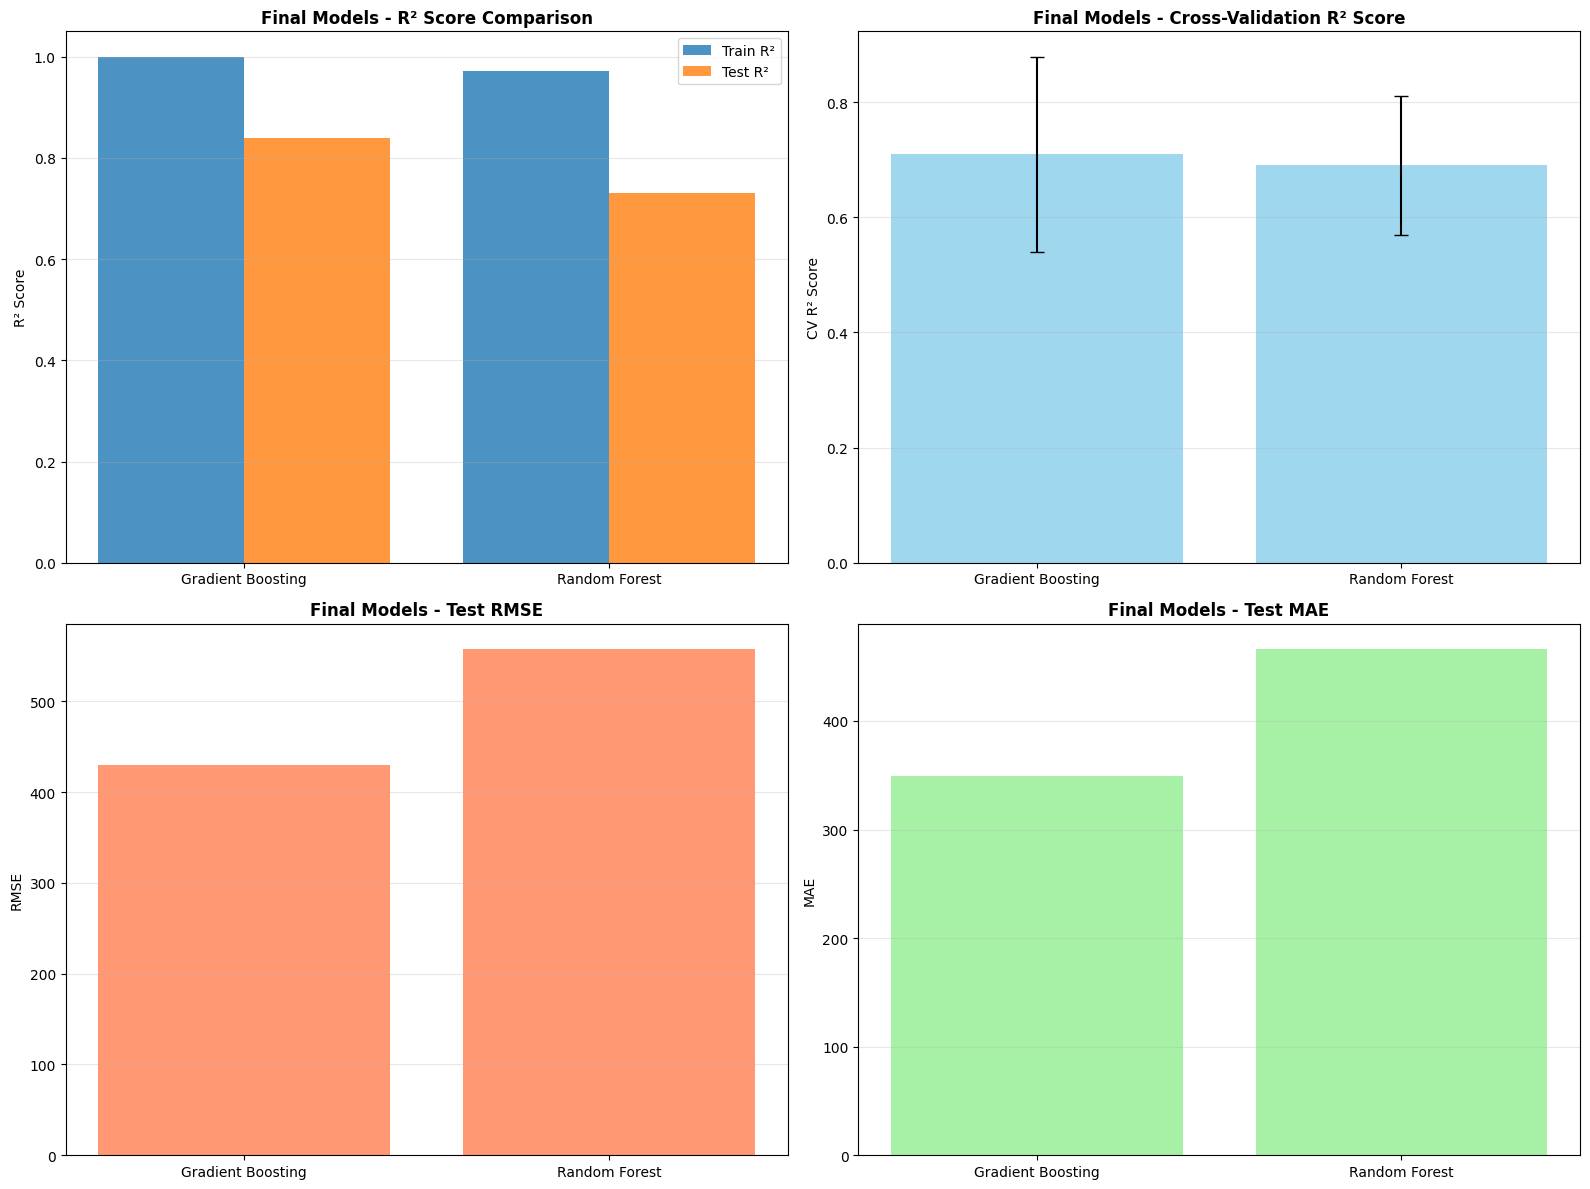

In [305]:
model_names = final_comparison['Model']
x_pos = np.arange(len(model_names))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Score comparison
axes[0, 0].bar(x_pos - 0.2, final_comparison['Train_R2'], 0.4, label='Train R²', alpha=0.8)
axes[0, 0].bar(x_pos + 0.2, final_comparison['Test_R2'], 0.4, label='Test R²', alpha=0.8)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(model_names, rotation=0)
axes[0, 0].set_title('Final Models - R² Score Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# CV Score comparison with error bars
axes[0, 1].bar(model_names, final_comparison['CV_Score'], alpha=0.8,
               yerr=final_comparison['CV_Std'], capsize=5, color='skyblue')
axes[0, 1].set_title('Final Models - Cross-Validation R² Score', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('CV R² Score')
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# RMSE comparison
axes[1, 0].bar(model_names, final_comparison['Test_RMSE'], alpha=0.8, color='coral')
axes[1, 0].set_title('Final Models - Test RMSE', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# MAE comparison
axes[1, 1].bar(model_names, final_comparison['Test_MAE'], alpha=0.8, color='lightgreen')
axes[1, 1].set_title('Final Models - Test MAE', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [306]:
# Best model analysis
best_model_name = final_comparison.loc[final_comparison['Test_R2'].idxmax(), 'Model']
print(f"\n11.3 Best Model: {best_model_name}")
print(f"Test R²: {final_model_results[best_model_name]['test_r2']:.4f}")
print(f"Test RMSE: {final_model_results[best_model_name]['test_rmse']:,.2f}")
print(f"Test MAE: {final_model_results[best_model_name]['test_mae']:,.2f}")
print(f"CV R² Score: {final_model_results[best_model_name]['cv_score_mean']:.4f}")


11.3 Best Model: Gradient Boosting
Test R²: 0.8400
Test RMSE: 429.80
Test MAE: 349.26
CV R² Score: 0.7090


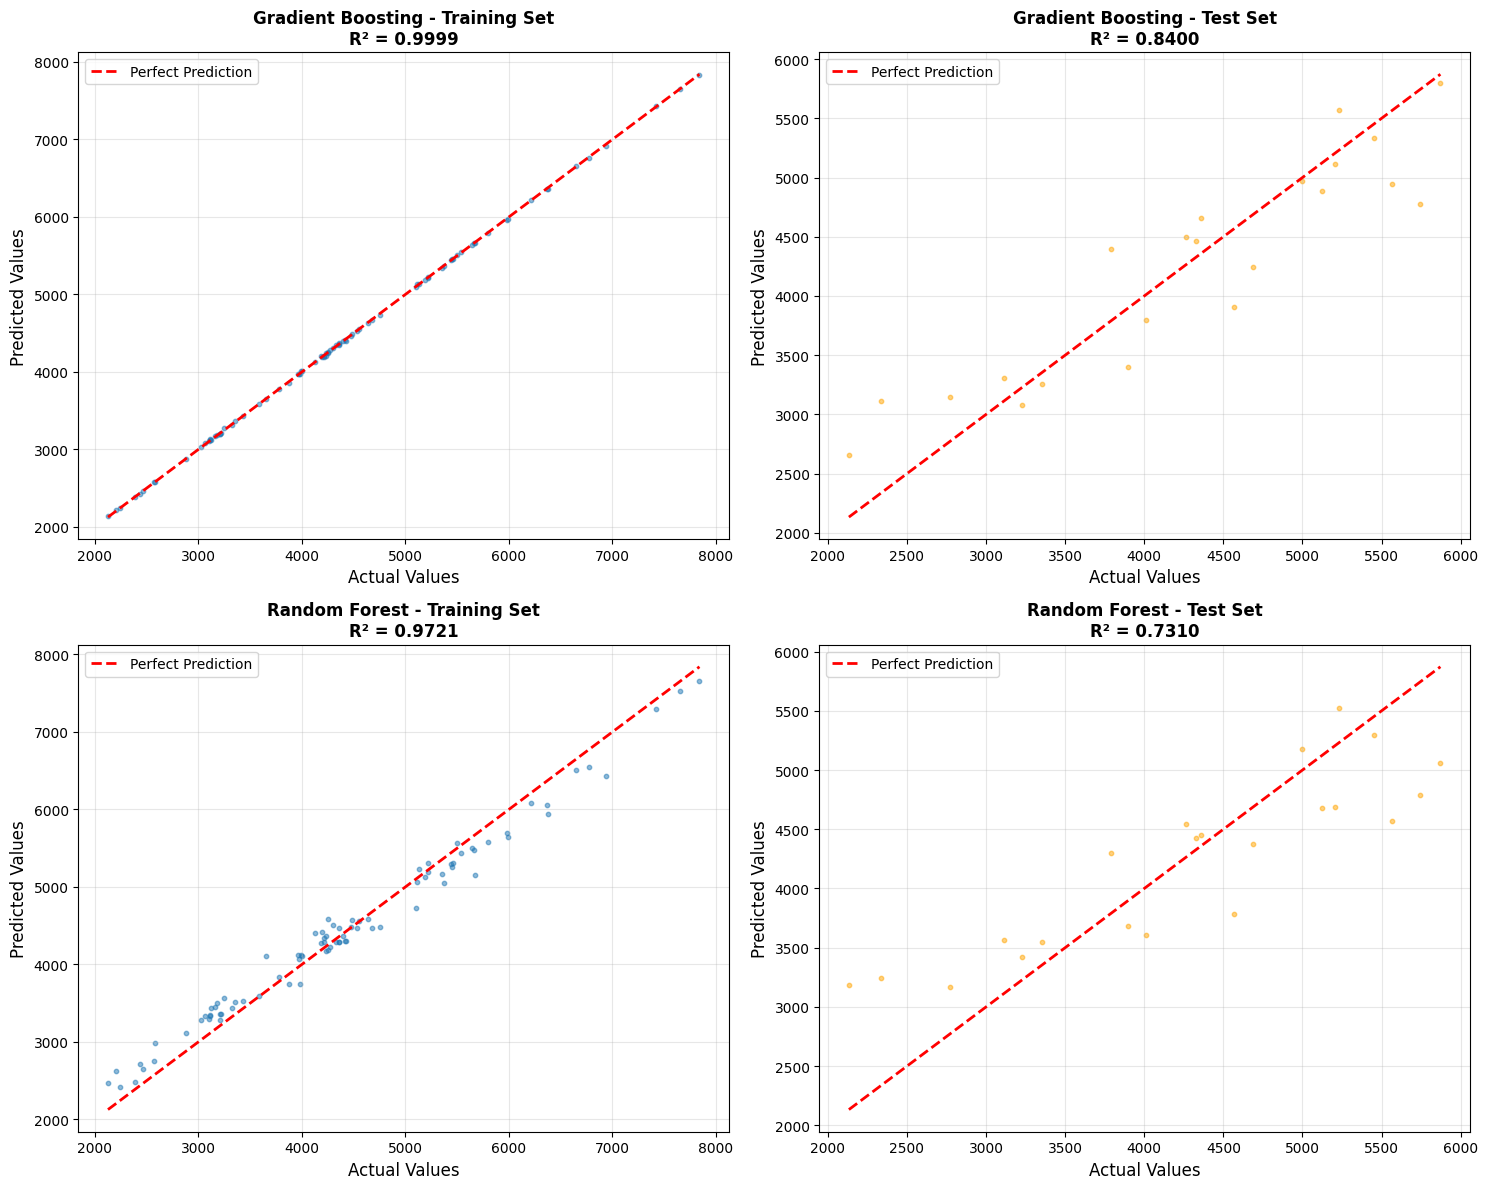

In [307]:
# Prediction plots for final models
fig, axes = plt.subplots(len(final_model_results), 2, figsize=(15, 6 * len(final_model_results)))

# Ensure axes is always 2D
if len(final_model_results) == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, results) in enumerate(final_model_results.items()):
    # Training predictions
    axes[idx, 0].scatter(y_train, results['y_train_pred'], alpha=0.5, s=10)
    axes[idx, 0].plot(
        [y_train.min(), y_train.max()],
        [y_train.min(), y_train.max()],
        'r--', lw=2, label='Perfect Prediction'
    )
    axes[idx, 0].set_xlabel('Actual Values', fontsize=12)
    axes[idx, 0].set_ylabel('Predicted Values', fontsize=12)
    axes[idx, 0].set_title(
        f'{model_name} - Training Set\nR² = {results["train_r2"]:.4f}',
        fontsize=12,
        fontweight='bold'
    )
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)

    # Test predictions
    axes[idx, 1].scatter(y_test, results['y_test_pred'], alpha=0.5, s=10, color='orange')
    axes[idx, 1].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'r--', lw=2, label='Perfect Prediction'
    )
    axes[idx, 1].set_xlabel('Actual Values', fontsize=12)
    axes[idx, 1].set_ylabel('Predicted Values', fontsize=12)
    axes[idx, 1].set_title(
        f'{model_name} - Test Set\nR² = {results["test_r2"]:.4f}',
        fontsize=12,
        fontweight='bold'
    )
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


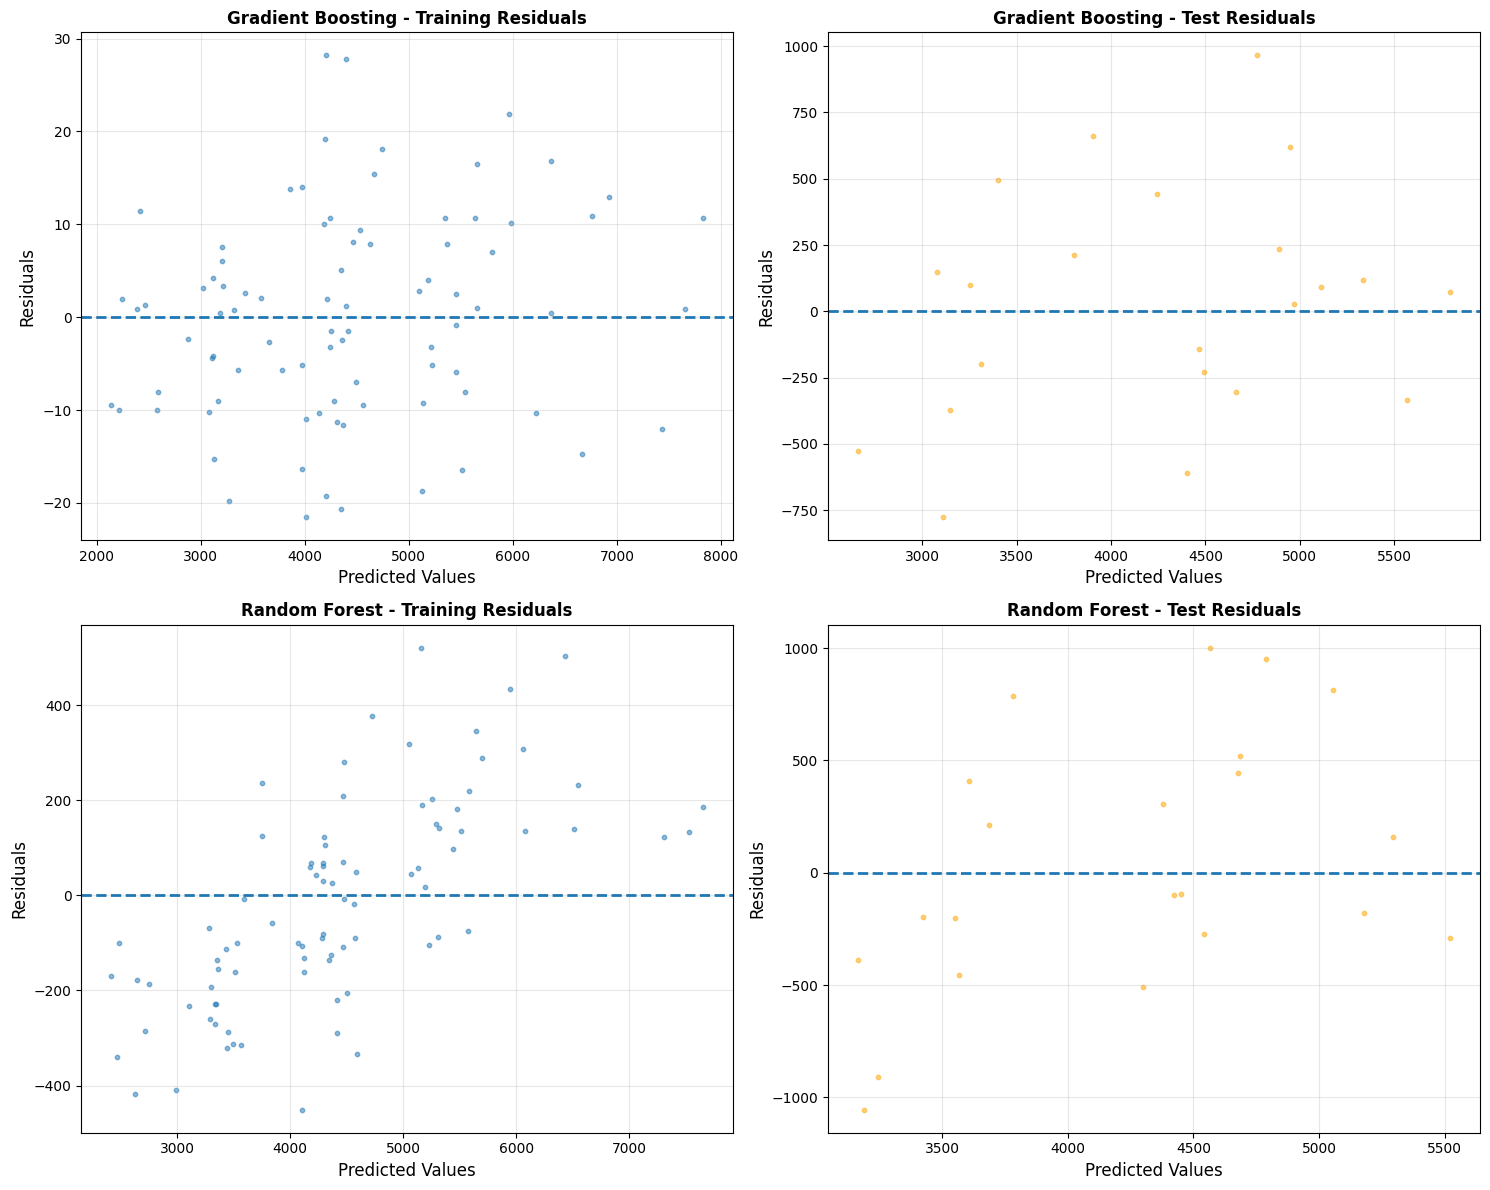

In [308]:
# Residual analysis for final models
fig, axes = plt.subplots(len(final_model_results), 2, figsize=(15, 6 * len(final_model_results)))

# Ensure axes is always 2D
if len(final_model_results) == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, results) in enumerate(final_model_results.items()):
    # Training residuals
    train_residuals = y_train - results['y_train_pred']
    axes[idx, 0].scatter(results['y_train_pred'], train_residuals, alpha=0.5, s=10)
    axes[idx, 0].axhline(y=0, linestyle='--', linewidth=2)
    axes[idx, 0].set_xlabel('Predicted Values', fontsize=12)
    axes[idx, 0].set_ylabel('Residuals', fontsize=12)
    axes[idx, 0].set_title(f'{model_name} - Training Residuals', fontsize=12, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)

    # Test residuals
    test_residuals = y_test - results['y_test_pred']
    axes[idx, 1].scatter(results['y_test_pred'], test_residuals, alpha=0.5, s=10, color='orange')
    axes[idx, 1].axhline(y=0, linestyle='--', linewidth=2)
    axes[idx, 1].set_xlabel('Predicted Values', fontsize=12)
    axes[idx, 1].set_ylabel('Residuals', fontsize=12)
    axes[idx, 1].set_title(f'{model_name} - Test Residuals', fontsize=12, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [309]:
df.head()

,Genotype,Replication,Plant Height (PH),Number of Pods (NP),Biological Weight (BW),Sugars (Su),Relative Water Content in Leaves (RWCL),ChlorophyllA663,Chlorophyllb649,Protein Percentage (PPE),Weight of 300 Seeds (W3S),Leaf Area Index (LAI),Seed Yield per Unit Area (SYUA),Number of Seeds per Pod (NSP),Protein Content (PCO)
0,C1S1G5,R1,50.5,130.3,111.0,0.433,0.732,1.4,3.1,33.2,33.6,0.08,5567.4,1.86,0.82
1,C2S3G4,R1,44.5,132.0,80.0,0.334,0.674,7.1,2.2,38.5,34.4,0.09,2245.5,1.87,0.13
2,C2S1G6,R1,52.2,150.0,83.0,0.490,0.677,1.8,1.3,33.6,35.2,0.07,4326.7,2.04,0.15
3,C1S1G1,R1,50.5,140.8,66.0,0.163,0.745,1.1,3.0,33.5,52.3,0.09,6214.5,2.20,0.14
4,C1S2G6,R2,49.2,175.6,73.0,0.795,0.725,7.5,2.1,39.6,31.2,0.10,3897.8,1.88,0.60
